<a href="https://colab.research.google.com/github/ChetanAIML/Movie-Recommendation/blob/main/Movie-Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
from sklearn.preprocessing import MinMaxScaler
from skimage import io
'''import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls'''

# plt.rc('font', family='Malgun Gothic')
plt.rcParams['font.family'] = 'Arial'
pyo.init_notebook_mode()

In [ ]:
import pandas as pd
import numpy as np
import random

df = pd.read_csv("/content/movies.csv")

# Poster import data
poster_df = df.copy()
poster_df = poster_df[['id','title','poster_path','backdrop_path']]

# Data frame to use
df.drop(columns = ['backdrop_path','poster_path','recommendations'],inplace = True)
df.head()

id                              title  \
0  615656                  Meg 2: The Trench   
1  758323                The Pope's Exorcist   
2  667538   Transformers: Rise of the Beasts   
3  640146  Ant-Man and the Wasp: Quantumania   
4  677179                          Creed III   

                             genres original_language  \
0     Action-Science Fiction-Horror                en   
1           Horror-Mystery-Thriller                en   
2  Action-Adventure-Science Fiction                en   
3  Action-Adventure-Science Fiction                en   
4                      Drama-Action                en   

                                            overview  popularity  \
0  An exploratory dive into the deepest depths of...    8763.998   
1  Father Gabriele Amorth Chief Exorcist of the V...    5953.227   
2  When a new threat capable of destroying the en...    5409.104   
3  Super-Hero partners Scott Lang and Hope van Dy...    4425.387   
4  After dominating the boxing world Adonis Creed...    3994.342   

                                production_companies release_date  \
0  Apelles Entertainment-Warner Bros. Pictures-di...   2023-08-02   
1  Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...   2023-04-05   
2  Skydance-Paramount-di Bonaventura Pictures-Bay...   2023-06-06   
3             Marvel Studios-Kevin Feige Productions   2023-02-15   
4  Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...   2023-03-01   

        budget      revenue  runtime    status  \
0  129000000.0  352056482.0    116.0  Released   
1   18000000.0   65675816.0    103.0  Released   
2  200000000.0  407045464.0    127.0  Released   
3  200000000.0  475766228.0    125.0  Released   
4   75000000.0  269000000.0    116.0  Released   

                                             tagline  vote_average  \
0                                  Back for seconds.         7.079   
1  Inspired by the actual files of Father Gabriel...         7.433   
2                                     Unite or fall.         7.340   
3            Witness the beginning of a new dynasty.         6.507   
4                      You can't run from your past.         7.262   

   vote_count                                            credits  \
0      1365.0  Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...   
1       545.0  Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...   
2      1007.0  Anthony Ramos-Dominique Fishback-Luna Lauren V...   
3      2811.0  Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...   
4      1129.0  Michael B. Jordan-Tessa Thompson-Jonathan Majo...   

                                            keywords  
0                based on novel or book-sequel-kaiju  
1  spain-rome italy-vatican-pope-pig-possession-c...  
2  peru-alien-end of the world-based on cartoon-b...  
3  hero-ant-sequel-superhero-based on comic-famil...  
4  philadelphia pennsylvania-husband wife relatio...

In [ ]:
random.seed(25)

# persona_A : Who watched 100 documentary movies (seed fixed random)
persona_A = df[df['genres'] == 'Documentary']
persona_A.index = np.arange(len(persona_A))

seen = list()
for i in range(100) : seen.append(random.randint(0, len(persona_A)-1))
persona_A = persona_A.loc[seen]

# persona_B : Who watched 100 movies in it language (seed fixed random)
persona_B = df[df['original_language'] == 'it']
persona_B.index = np.arange(len(persona_B))

seen = list()
for i in range(100) : seen.append(random.randint(0, len(persona_B)-1))
persona_B = persona_B.loc[seen]

# persona_C : Who watched 100 movies with a rating of 8 or higher (seed fixed random)
persona_C = df[df['vote_average'] > 8]
persona_C.index = np.arange(len(persona_C))

seen = list()
for i in range(100) : seen.append(random.randint(0, len(persona_C)-1))
persona_C = persona_C.loc[seen]

# For smooth preprocessing,
# persona_A is a list containing index numbers, and later access to df using that index number
persona_A = persona_A.id.values.tolist()
persona_B = persona_B.id.values.tolist()
persona_C = persona_C.id.values.tolist()

In [ ]:
# No persona ID duplicate value
print(len(set(persona_A)))
print(len(set(persona_B)))
print(len(set(persona_C)))

100
100
100


In [ ]:
# id Overlapping 116362 pieces
print(len(df[df['id'].duplicated(keep=False)]['id']))

#Unique number of duplicated IDs 55446
print(len(df[df['id'].duplicated(keep=False)]['id'].value_counts().index))

115802
55187


In [ ]:
print("< What is the difference between duplicate IDs and other variables >")
for col in df.columns:
    print(col, end = " : ")
    dup_df= df.loc[df[df['id'].duplicated(keep=False)].index]
    t = dup_df.groupby('id')[col].nunique(dropna=False)
    t= t[t>1]
    print(t.value_counts().sum())
# popularity, vote_average, vote_count -> Average numeric variables
# production_companies 963060, 385282, 686971 -> It's just the same, #First substitute
# keywords, credits -> Longer contains more than short -> Replace with longer

< What is the difference between duplicate IDs and other variables >
id : 0
title : 0
genres : 0
original_language : 0
overview : 0
popularity : 55127
production_companies : 3
release_date : 0
budget : 0
revenue : 0
runtime : 0
status : 0
tagline : 0
vote_average : 89
vote_count : 128
credits : 108
keywords : 14


In [ ]:
# Temporary saving of id order
origin_id_order = df.drop_duplicates(subset='id', keep='first').id

In [ ]:
# Only those with duplicate id are selected: dup_df
dup_df= df.loc[df[df['id'].duplicated(keep=False)].index]

# Keywords are replaced by long ones
dup_df['keywords'].fillna("",inplace = True)
new_keywords = dup_df.loc[dup_df.groupby('id')['keywords'].apply(lambda x: x.str.len().idxmax())][['id','keywords']]
new_keywords.set_index('id', inplace = True)
new_keywords = new_keywords['keywords']

# credits are replaced by long ones
dup_df['credits'].fillna("",inplace = True)
new_credits = dup_df.loc[dup_df.groupby('id')['credits'].apply(lambda x: x.str.len().idxmax())][['id','credits']]
new_credits.set_index('id', inplace = True)
new_credits = new_credits['credits']

# Three numeric variables are averaged to replace them
new_popularity = dup_df.groupby("id")['popularity'].mean()
new_vote_average = dup_df.groupby("id")['vote_average'].mean()
new_vote_count = dup_df.groupby("id")['vote_count'].mean()

In [ ]:
# Remove all subordinate id from df
df.drop_duplicates(subset='id', keep=False ,inplace=True)

# id changed unique in duplicate id data frame (dup_df)
dup_df.drop_duplicates(subset='id', keep='first' ,inplace=True)

# inner join to dup_df
join = [new_keywords, new_credits,new_popularity,new_vote_average,new_vote_count]

temp_df =dup_df.copy()
temp_df.drop(columns=['keywords','credits','popularity','vote_average','vote_count'], inplace = True)

for j in join:
    temp_df = pd.merge(temp_df, j, on ='id', how='left')
temp_df = temp_df[df.columns]

# Put dup_df into df and sort id in the existing order
df = pd.concat([df, temp_df], axis = 0)
df = df.set_index('id').loc[origin_id_order].reset_index()
df

id                                             title  \
0       615656                                 Meg 2: The Trench   
1       758323                               The Pope's Exorcist   
2       667538                  Transformers: Rise of the Beasts   
3       640146                 Ant-Man and the Wasp: Quantumania   
4       677179                                         Creed III   
...        ...                                               ...   
662078  741629                                        Blitzkrieg   
662079  430327  Con aura senz'aura. Viaggio ai confini dell'arte   
662080  633623                                     Midsommarvaka   
662081  294742                                 Gospođa- Slobodan   
662082  968161                                     Gising Sining   

                                  genres original_language  \
0          Action-Science Fiction-Horror                en   
1                Horror-Mystery-Thriller                en   
2       Action-Adventure-Science Fiction                en   
3       Action-Adventure-Science Fiction                en   
4                           Drama-Action                en   
...                                  ...               ...   
662078                            Horror                es   
662079                               NaN                it   
662080                             Music                xx   
662081                               NaN                en   
662082                               NaN                tl   

                                                 overview  popularity  \
0       An exploratory dive into the deepest depths of...    8763.998   
1       Father Gabriele Amorth Chief Exorcist of the V...    5953.227   
2       When a new threat capable of destroying the en...    5409.104   
3       Super-Hero partners Scott Lang and Hope van Dy...    4425.387   
4       After dominating the boxing world Adonis Creed...    3994.342   
...                                                   ...         ...   
662078  A child becomes paralyzed with worry that an i...       0.600   
662079                                                NaN       0.600   
662080  Midsummer celebration with dance and courtship...       0.600   
662081                                  Short video spot.       0.600   
662082  In a country where fascism foolishness of peop...       0.600   

                                     production_companies release_date  \
0       Apelles Entertainment-Warner Bros. Pictures-di...   2023-08-02   
1       Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...   2023-04-05   
2       Skydance-Paramount-di Bonaventura Pictures-Bay...   2023-06-06   
3                  Marvel Studios-Kevin Feige Productions   2023-02-15   
4       Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...   2023-03-01   
...                                                   ...          ...   
662078                                                NaN   2020-10-01   
662079                                                NaN   2003-02-02   
662080                                         SF Studios   1947-12-26   
662081                                                NaN          NaN   
662082                                          Studio RD          NaN   

             budget      revenue  runtime    status  \
0       129000000.0  352056482.0    116.0  Released   
1        18000000.0   65675816.0    103.0  Released   
2       200000000.0  407045464.0    127.0  Released   
3       200000000.0  475766228.0    125.0  Released   
4        75000000.0  269000000.0    116.0  Released   
...             ...          ...      ...       ...   
662078          0.0          0.0      8.0  Released   
662079          0.0          0.0      NaN  Released   
662080          0.0          0.0     11.0  Released   
662081          0.0          0.0      5.0  Released   
662082          0.0          0.0     19.0  Released   

                       

In [ ]:
display(df[df['title'].isnull()])
title_drop = df[df['title'].isnull()]['id'].index.tolist()
df.drop(index= title_drop,inplace = True) #Drop the row bar below.

id title       genres original_language overview  popularity  \
399950  931166   NaN  Documentary                en      NaN         0.6   
434914  931169   NaN          NaN                en      NaN         0.6   
436437  819411   NaN          NaN                en      NaN         0.6   
558688  276521   NaN          NaN                en      NaN         0.6   

       production_companies release_date  budget  revenue  runtime    status  \
399950                  NaN          NaN     0.0      0.0      0.0  Released   
434914                  NaN          NaN     0.0      0.0      0.0  Released   
436437                  NaN          NaN     0.0      0.0     90.0  Released   
558688                  NaN   2014-06-13     0.0      0.0      0.0  Released   

       tagline  vote_average  vote_count credits keywords  
399950     NaN           0.0         0.0     NaN      NaN  
434914     NaN           0.0         0.0     NaN      NaN  
436437     NaN           0.0         0.0     NaN      NaN  
558688     NaN           0.0         0.0     NaN      NaN

In [ ]:
print(len(df[df['title'].duplicated(keep=False)])) #the number of movies with overlapping titles
df[df['title']=="Plane"] #But since the title is the same and it's a different movie, let's distinguish it by ID

122761


id  title                     genres original_language  \
9       646389  Plane  Action-Adventure-Thriller                en   
110289  461476  Plane                      Drama                fr   

                                                 overview  popularity  \
9       After a heroic job of successfully landing his...    2618.646   
110289  Absent for several months William eldest of th...       1.537   

                                     production_companies release_date  \
9       MadRiver Pictures-Di Bonaventura Pictures-G-BA...   2023-01-12   
110289                                                NaN   2017-05-18   

            budget     revenue  runtime    status  \
9       25000000.0  51000000.0    107.0  Released   
110289         0.0         0.0     19.0  Released   

                               tagline  vote_average  vote_count  \
9       Survive together or die alone.         6.901       785.0   
110289                             NaN         0.000         0.0   

                                                  credits  \
9       Gerard Butler-Mike Colter-Yoson An-Tony Goldwy...   
110289                                                NaN   

                                                 keywords  
9       pilot-airplane-philippines-held hostage-plane ...  
110289                                                NaN

In [ ]:
print("Persona A's title Missing values",list(set(title_drop).intersection(persona_A)))
print("Persona B's title Missing values",list(set(title_drop).intersection(persona_B)))
print("Persona C's title Missing values",list(set(title_drop).intersection(persona_C)))

Persona A's title Missing values []
Persona B's title Missing values []
Persona C's title Missing values []


In [ ]:
df['original_language'].value_counts() # 167 languages with all unique values

en    345286
fr     41580
es     37830
de     34808
ja     25667
       ...  
cv         1
ii         1
os         1
ia         1
rn         1
Name: original_language, Length: 167, dtype: int64

In [ ]:
df['original_language'].isnull().sum() # No missing values, very nice

0

In [ ]:
df[['vote_average','vote_count']].isnull().sum() # No missing values

vote_average    0
vote_count      0
dtype: int64

In [ ]:
len(df[df['vote_count']==0]) #The number of votes is 0.  -> 426574 votes

400197

In [ ]:
df[(df['vote_count'] > 0) & (df['vote_average'] ==0)]['vote_count'].value_counts()
# If there were voters and the rating was zero, all of them had less than three voters -> The movie seems to have really given zero points because it was so bad.
# If several people voted and all zero points are zero, we can judge that there is an error in the data, but this seems to be true

1.0    341
2.0     18
3.0      8
0.5      1
Name: vote_count, dtype: int64

In [ ]:
# 0.5 votes is treated as -> 0
print(f"Vote count of 1352 index : {df['vote_count'].loc[1352]}")
df['vote_count'].loc[1352] = 0
print("__________After processing__________")
display(df.loc[1352])

Vote count of 1352 index : 3934.0
__________After processing__________


<ipython-input-20-8df8a7a2962f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id                                                                   1735
title                               The Mummy: Tomb of the Dragon Emperor
genres                                           Adventure-Action-Fantasy
original_language                                                      en
overview                Archaeologist Rick O'Connell travels to China ...
popularity                                                         49.785
production_companies    Universal Pictures-China Film Co-Production Co...
release_date                                                   2008-07-01
budget                                                        145000000.0
revenue                                                       403449830.0
runtime                                                             112.0
status                                                           Released
tagline                                               A New Evil Awakens.
vote_average                          

In [ ]:
display(df[(df['vote_count']==0) & (df['vote_average'] >0)]) #The number of votes is zero, but the voting score is not zero?? Weirdness
# Hypothesis: There is an error in the data. -> Replace rating with 0
df['vote_average'][(df['vote_count']==0) & (df['vote_average'] >0)] = 0
display(df[(df['vote_count']==0) & (df['vote_average'] ==0)])

id                                  title  \
1352      1735  The Mummy: Tomb of the Dragon Emperor   
13114   656156                        A Man of Reason   
30919   826448                                Buffoon   
40755   826056              Chinese Speaking Vampires   
48221   502490                      Lolita per sempre   
...        ...                                    ...   
637977  438544                Across the Mexican Line   
641604  576322                     Ghost in the Water   
651344  654029              Straight from the Suburbs   
651718  576214                       Les yeux ouverts   
654344  646913                     Komm in den Garten   

                          genres original_language  \
1352    Adventure-Action-Fantasy                en   
13114      Action-Drama-Thriller                ko   
30919               Drama-Comedy                ta   
40755       Action-Comedy-Horror                en   
48221                      Drama                it   
...                          ...               ...   
637977   Drama-History-Adventure                en   
641604     Horror-Drama-TV Movie                en   
651344                       NaN                en   
651718                       NaN                fr   
654344               Documentary                de   

                                                 overview  popularity  \
1352    Archaeologist Rick O'Connell travels to China ...      49.785   
13114   After 10 years of incarceration on behalf of h...      11.126   
30919   Two Koothu artistes become pawns in a politica...       5.630   
40755   Tony a desperate actor who becomes a vampire a...       4.305   
48221   Photographer Cosmo a great provincial seducer ...       3.653   
...                                                   ...         ...   
637977  During the Mexican Revolution a female spy for...       0.600   
641604  Judith Allchurch and Ian Stevens star in this ...       0.600   
651344  Mary a troubled teenager lives with her mother...       0.600   
651718                                                NaN       0.600   
654344  A portrait of three friends from the GDR. Diet...       0.600   

                                     production_companies release_date  \
1352    Universal Pictures-China Film Co-Production Co...   2008-07-01   
13114                     Acemaker Movieworks-Studio Take   2022-09-13   
30919               Stone Bench Creations-Passion Studios   2022-09-23   
40755                                   Kung Pao Pictures   2021-01-09   
48221                                                 NaN   1991-02-02   
...                                                   ...          ...   
637977                                                NaN   1911-04-27   
641604                                                BBC   1982-12-31   
651344                                                NaN   1998-01-01   
651718                                                NaN   2010-11-03   
654344                    DEFA-Studio für Dokumentarfilme   1990-12-22   

             budget      revenue  runtime    status  \
1352    145000000.0  403449830.0    112.0  Released   
13114           0.0          0.0    103.0  Released   
30919           0.0          0.0    119.0  Released   
40755      100000.0          0.0     80.0  Released   
48221           0.0          0.0     73.0  Released   
...             ...          ...      ...       ...   
637977          0.0          0.0     13.0  Released   
641604          0.0          0.0     55.0  Released   
651344          0.0          0.0     25.0  Released   
651718          0.0          0.0      NaN  Released   
654344          0.0          0.0     89.0  Released   

                                             tagline  vote_average  \
1352                             A New Evil Awakens.           5.5   
13114                                            NaN           8.0   
30919                                    

<ipython-input-21-617b47d3791a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id                                             title  \
122     836988                         Chasing Love Time Machine   
196     820525                                  After Everything   
205     809363                               La novia de América   
232     860419                 Exchange Sex With A Friend Couple   
241     860407                                     人妻性奴隶：美人妻调教日记   
...        ...                                               ...   
662077  198148                                    Liberté chérie   
662079  430327  Con aura senz'aura. Viaggio ai confini dell'arte   
662080  633623                                     Midsommarvaka   
662081  294742                                 Gospođa- Slobodan   
662082  968161                                     Gising Sining   

                genres original_language  \
122      Drama-Romance                zh   
196      Romance-Drama                en   
205     Comedy-Romance                es   
232      Romance-Drama                ko   
241                NaN                zh   
...                ...               ...   
662077     Documentary                fr   
662079             NaN                it   
662080           Music                xx   
662081             NaN                en   
662082             NaN                tl   

                                                 overview  popularity  \
122     Young student finds a time machine and venture...     288.420   
196     Besieged by writer’s block and the crushing br...     199.146   
205                                                   NaN     193.283   
232     An erotic film about the reckless sexual acts ...     176.357   
241                                                   NaN     169.730   
...                                                   ...         ...   
662077                                                NaN       0.600   
662079                                                NaN       0.600   
662080  Midsummer celebration with dance and courtship...       0.600   
662081                                  Short video spot.       0.600   
662082  In a country where fascism foolishness of peop...       0.600   

                                     production_companies release_date  \
122                                                   NaN   2018-04-04   
196                              Voltage Pictures-Wattpad   2023-09-13   
205     Tornasol Films-ANIMAL DE LUZ FILMS-Latido Film...   2023-02-17   
232                                                   NaN   2019-06-21   
241                                                   NaN   2017-07-07   
...                                                   ...          ...   
662077                                                NaN   2013-06-05   
662079                                                NaN   2003-02-02   
662080                                         SF Studios   1947-12-26   
662081                                                NaN          NaN   
662082                                          Studio RD          NaN   

            budget  revenue  runtime    status tagline  vote_average  \
122            0.0      0.0     63.0  Released     NaN           0.0   
196     14000000.0      0.0     93.0  Released     NaN           0.0   
205            0.0      0.0      0.0  Released     NaN           0.0   
232            0.0      0.0     60.0  Released     NaN           0.0   
241            0.0      0.0      0.0  Released     NaN           0.0   
...            ...      ...      ...       ...     ...           ...   
662077         0.0      0.0     55.0  Released     NaN           0.0   
662079         0.0      0.0      NaN  Released     NaN           0.0   
662080         0.0      0.0     11.0  Released     NaN           0.0   
662081         0.0      0.0      5.0  Released     NaN           0.0   
662082         0.0      0.0     19.0  Released     NaN           0.0   

        vote_count                 

In [ ]:
df['production_companies'].isnull().sum()
df['production_companies'].fillna("", inplace = True)

In [ ]:
df['production_companies']

0         Apelles Entertainment-Warner Bros. Pictures-di...
1         Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...
2         Skydance-Paramount-di Bonaventura Pictures-Bay...
3                    Marvel Studios-Kevin Feige Productions
4         Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...
                                ...                        
662078                                                     
662079                                                     
662080                                           SF Studios
662081                                                     
662082                                            Studio RD
Name: production_companies, Length: 662079, dtype: object

In [ ]:
from collections import Counter

company_list = [word for words in df['production_companies'].values for word in words]
company_count = dict(Counter(company_list))
# company_count = dict(sorted(company_count.items())) #Dictionary Sequencing
company_count = dict(sorted(company_count.items(), key=lambda x: x[1], reverse = True))
company_count

{' ': 654361,
 'i': 654260,
 'e': 543600,
 'o': 528008,
 'n': 501912,
 'a': 478641,
 'r': 456598,
 't': 455104,
 's': 370841,
 'l': 324066,
 'm': 272391,
 'u': 262668,
 'd': 218892,
 'c': 209977,
 '-': 190790,
 'F': 171968,
 'P': 149665,
 'C': 118379,
 'S': 95576,
 'h': 92906,
 'p': 78004,
 'A': 75466,
 'g': 74782,
 'y': 73567,
 'M': 71918,
 'T': 65210,
 'B': 62116,
 'k': 61509,
 'E': 60343,
 'v': 54941,
 'R': 49973,
 'f': 46218,
 'D': 42872,
 'L': 42735,
 'I': 40647,
 'G': 37850,
 'b': 36548,
 'N': 35786,
 '.': 33973,
 'W': 29282,
 'V': 27865,
 'H': 27759,
 'w': 27651,
 'O': 25631,
 'K': 22688,
 'U': 18850,
 'é': 17593,
 'z': 17270,
 'x': 13648,
 'J': 10384,
 '(': 9556,
 ')': 9554,
 'j': 9097,
 'Z': 7797,
 'á': 6603,
 '2': 6254,
 '&': 5945,
 '0': 4870,
 '1': 4768,
 'Y': 4689,
 'ó': 3861,
 "'": 3852,
 'q': 3422,
 '3': 3357,
 'í': 2698,
 '4': 2687,
 '/': 2599,
 'ü': 2414,
 '+': 2382,
 'ç': 2347,
 '|': 2040,
 'X': 2029,
 'è': 1990,
 'Q': 1895,
 'Č': 1759,
 '5': 1678,
 'ý': 1378,
 'õ': 13

In [ ]:
df['popularity'].isnull().sum()# No missing values

0

In [ ]:
print(df['popularity'].min())
print(df['popularity'].max())

0.6
8763.998


In [ ]:
print(df['budget'].isnull().sum())
print(len(df[df['budget']==0]))

# The key to "budget" is 0,1,2,3..I don't know if the production cost is like that

0
628607


In [ ]:
df[df['budget']==1] # Did the movie "down" really cost a dollar? How am I going to deal with it...

id                                            title  \
1263    946030                               Onsen porno chitai   
1973    571055                                             Down   
10282   849266                                            Punga   
11791   828664                                       One Dollar   
13882   952936                                     PSYCHOTROPIA   
...        ...                                              ...   
645501  541903                                   Runaway Dreams   
647750  648468                                            Мария   
647984  585038                                        At a Loss   
649313  648671                   A gente finge que não dói mais   
652831  516679  Young Indiana Jones and the Curse of the Jackal   

                        genres original_language  \
1263                       NaN                ja   
1973     Horror-Drama-Thriller                en   
10282                    Drama                en   
11791   Comedy-Drama-Adventure                en   
13882            Drama-Mystery                fr   
...                        ...               ...   
645501                   Drama                en   
647750   History-Drama-Romance                ru   
647984           Drama-Romance                en   
649313                     NaN                pt   
652831        Action-Adventure                en   

                                                 overview  popularity  \
1263                                 Nikkatsu Roman Porno      52.573   
1973    A pair of coworkers gets trapped in an elevato...      38.114   
10282   Punga is a hybrid film and series project abou...      13.012   
11791   Over the course of one day in the San Fernando...      11.893   
13882                                                 NaN      10.724   
...                                                   ...         ...   
645501  A young girl runs away and is forced to become...       0.600   
647750                                                NaN       0.600   
647984  With relationships sometimes comes loss. Emily...       0.600   
649313                                                NaN       0.600   
652831  Old professor Henry Jones tells two youth abou...       0.600   

                  production_companies release_date  budget  revenue  runtime  \
1263               Nakagawa Production   1972-01-08     1.0      0.0     64.0   
1973              Blumhouse Television   2019-02-01     1.0      0.0     82.0   
10282                                    2022-08-02     1.0      0.0    306.0   
11791                                    2022-12-01     1.0      0.0     30.0   
13882   WASSILEI-Blackstone Production   2022-05-14     1.0      0.0      0.0   
...                                ...          ...     ...      ...      ...   
645501                                   1989-09-09     1.0      0.0     92.0   
647750                                   2016-11-28     1.0      1.0      NaN   
647984               Tower Productions   2018-11-18     1.0      0.0     20.0   
649313                                          NaN     1.0      0.0      NaN   
652831                                   1992-03-04     1.0      0.0     85.0   

          status                                            tagline  \
1263    Released                                                NaN   
1973    Released         This Valentine's Day, fall head over heels   
10282   Released  Political and social work about a distant and ...   
11791   Released                                                NaN   
13882   Released                                                NaN   
...          ...                                                ...   
645501  Released  On the streets, the dream is always the first ...   
647750  Released                                                NaN   
647984  Released                                                NaN   
649313  Released      

In [ ]:
print(df['revenue'].isnull().sum())
print(len(df[df['revenue']==0]))

0
645773


In [ ]:
df[df['revenue']==1]  # The same is true of how we're going to do low-return cutoffs

id                       title                 genres  \
11477    14424           Sex and Death 101   Comedy-Romance-Drama   
12289   949273         TacoTown: The Movie        Thriller-Comedy   
13106   949460         TacoTown: The Movie        Thriller-Comedy   
26821    32834  MVP: Most Valuable Primate          Comedy-Family   
34733    25471           The King of Masks                  Drama   
...        ...                         ...                    ...   
638838  450775  The Everyday Guide to Wine                    NaN   
642074  649715                 SIN REVERSA                    NaN   
642946  536169          Citadel of Madness                    NaN   
647750  648468                       Мария  History-Drama-Romance   
653509  550818                        Soap           Comedy-Drama   

       original_language                                           overview  \
11477                 en  A guy's life is turned around by an email whic...   
12289                 en  Ordinary citizen Daniel Robbins's life is chan...   
13106                 en  Ordinary citizen Daniel Robbins's life is chan...   
26821                 en  Jack is a three-year-old chimpanzee who has be...   
34733                 zh  Wang Bianlian is an aging street performer kno...   
...                  ...                                                ...   
638838                en  Master of Wine Jennifer Simonetti-Bryan will s...   
642074                es                                                NaN   
642946                en  High schooler Daniel Stone slowly loses his mi...   
647750                ru                                                NaN   
653509                en  When Sami breaks into a house he is disturbed ...   

        popularity                               production_companies  \
11477       12.112                   Avenue Pictures-Sandbar Pictures   
12289       11.596                                   TacoTales Movies   
13106       11.130                                   TacoTales Movies   
26821        6.430  Keystone Family Pictures-Funky Monkey Productions   
34733        5.025                                      Shaw Brothers   
...            ...                                                ...   
638838       0.600                                                      
642074       0.600                                   The Coxis Cinema   
642946       0.600                                                      
647750       0.600                                                      
653509       0.600                                                      

       release_date   budget  revenue  runtime    status  \
11477    2007-06-15      5.0      1.0    100.0  Released   
12289    2022-05-21      7.0      1.0     50.0  Released   
13106    2022-05-21      7.0      1.0     50.0  Released   
26821    2000-08-11      4.0      1.0     85.0  Released   
34733    1995-06-09      0.0      1.0    102.0  Released   
...             ...      ...      ...      ...       ...   
638838   2010-04-05    100.0      1.0     24.0  Released   
642074   2019-11-28      1.0      1.0      NaN  Released   
642946          NaN      1.0      1.0      4.0  Released   
647750   2016-11-28      1.0      1.0      NaN  Released   
653509   2015-05-30  10000.0      1.0     16.0  Released   

                                                  tagline  vote_average  \
11477                                                 NaN         6.098   
12289                            They're one in the same.         0.000   
13106                            They're one in the same.         0.000   
26821   Jack skates a little faster... Shoots a little...         4.800   
34733                                                 NaN         7.200   
...                                                   ...           ...   
638838                                                NaN        10.000   
642074                              

In [ ]:
df.sort_values('runtime', ascending = False)['runtime']

650249    50505050.0
586630    50189181.0
31569        51420.0
183931       43200.0
289643       14400.0
             ...    
662058           NaN
662065           NaN
662072           NaN
662073           NaN
662079           NaN
Name: runtime, Length: 662079, dtype: float64

In [ ]:
# Mr Marcus FriendBoop Facebook Adventures Runtime Find out and replace
df['runtime'][df['id'] == 660968] = 1370 # 22h 50m   1370m
df['runtime'][df['id'] == 660969] = 861  #  14h 21m   861m

<ipython-input-32-cc394db5f9a0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-cc394db5f9a0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df['credits'].value_counts()
df['genres'].value_counts()

Documentary                                           86418
Drama                                                 72586
Comedy                                                41885
Animation                                             21351
Music                                                 16643
                                                      ...  
Adventure-Action-Drama-History-TV Movie                   1
Drama-Romance-Comedy-Fantasy                              1
Animation-Fantasy-Comedy-Adventure-Science Fiction        1
Horror-Animation-Crime                                    1
Science Fiction-Mystery-Drama-Thriller                    1
Name: genres, Length: 11030, dtype: int64

In [ ]:
df['genres'].fillna("", inplace = True)
df['credits'].fillna("", inplace = True)
df['genres'] = df['genres'].str.split('-')
df['credits'] = df['credits'].str.split('-')

In [ ]:
# How to use it
has = df['genres'].apply(lambda x: 'Horror' in x)
df[has] #Thriller genre of movies

id                     title                             genres  \
0       615656         Meg 2: The Trench  [Action, Science Fiction, Horror]   
1       758323       The Pope's Exorcist        [Horror, Mystery, Thriller]   
6       614479   Insidious: The Red Door        [Horror, Mystery, Thriller]   
11      934433                 Scream VI        [Horror, Mystery, Thriller]   
16      968051                The Nun II        [Horror, Mystery, Thriller]   
...        ...                       ...                                ...   
661950  483644  Of Bloody Peony at Night                           [Horror]   
661960  529438               Reflections                           [Horror]   
661963  527717                    Selfie                           [Horror]   
662067  385075       The Mark of Dracula                           [Horror]   
662078  741629                Blitzkrieg                           [Horror]   

       original_language                                           overview  \
0                     en  An exploratory dive into the deepest depths of...   
1                     en  Father Gabriele Amorth Chief Exorcist of the V...   
6                     en  To put their demons to rest once and for all J...   
11                    en  Following the latest Ghostface killings the fo...   
16                    en  1956 – France. A priest is murdered. An evil i...   
...                  ...                                                ...   
661950                zh                                Taiwanese thriller.   
661960                en  A trip to the darkest realms of the subconscio...   
661963                en  A woman is haunted by a strange figure in her ...   
662067                en     A vampire acts mean toward a small rural town.   
662078                es  A child becomes paralyzed with worry that an i...   

        popularity                               production_companies  \
0         8763.998  Apelles Entertainment-Warner Bros. Pictures-di...   
1         5953.227  Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...   
6         3512.648  Blumhouse Productions-Stage 6 Films-Screen Gem...   
11        2472.802  Radio Silence-Project X Entertainment-Spyglass...   
16        1812.129  New Line Cinema-Atomic Monster-The Safran Company   
...            ...                                                ...   
661950       0.600                               Cinema Film Co. Ltd.   
661960       0.600                                                      
661963       0.600                                                      
662067       0.600                              Wildcat Entertainment   
662078       0.600                                                      

       release_date       budget      revenue  runtime    status  \
0        2023-08-02  129000000.0  352056482.0    116.0  Released   
1        2023-04-05   18000000.0   65675816.0    103.0  Released   
6        2023-07-05   16000000.0  175582093.0    107.0  Released   
11       2023-03-08   35000000.0  168541093.0    123.0  Released   
16       2023-09-06          0.0          0.0    110.0  Released   
...             ...          ...          ...      ...       ...   
661950   1982-01-01          0.0          0.0     82.0  Released   
661960   2018-06-11          0.0          0.0     18.0  Released   
661963   2015-04-11        500.0          0.0      7.0  Released   
662067   1997-01-01          0.0          0.0     88.0  Released   
662078   2020-10-01          0.0          0.0      8.0  Released   

                                                  tagline  vote_average  \
0                                       Back for seconds.         7.079   
1       Inspired by the actual files of Father Gabriel...         7.433   
6                             It ends where it all began.         6.750   
11                                   New York. New rules.         7.400   
16           The greatest evil in the Conjuri

In [ ]:
from collections import Counter

genres_list = [word for words in df['genres'].values for word in words]
genres_count = dict(Counter(genres_list))
genres_count

{'Action': 32617,
 'Science Fiction': 14899,
 'Horror': 32259,
 'Mystery': 13712,
 'Thriller': 32792,
 'Adventure': 17810,
 'Drama': 158954,
 'Crime': 24347,
 'Comedy': 98526,
 'Fantasy': 15295,
 'Animation': 39479,
 'Family': 20476,
 'Romance': 37363,
 'War': 8182,
 'History': 12079,
 'Documentary': 105552,
 'Music': 32836,
 'TV Movie': 16770,
 '': 199499,
 'Western': 7302}

In [ ]:
credits_list = [word for words in df['credits'].values for word in words]
credits_count = dict(Counter(credits_list))
credits_count

{'Jason Statham': 57,
 'Wu Jing': 55,
 'Shuya Sophia Cai': 2,
 'Sergio Peris': 29,
 'Mencheta': 28,
 'Skyler Samuels': 14,
 'Cliff Curtis': 49,
 'Page Kennedy': 12,
 'Sienna Guillory': 44,
 'Melissanthi Mahut': 5,
 'Kiran Sonia Sawar': 9,
 'Felix Mayr': 3,
 'Whoopie van Raam': 2,
 'Guo Tao': 45,
 'Robin Hill': 7,
 'Dai Lele': 14,
 'Sui Fong Ivy Tsui': 2,
 'Stewart Alexander': 11,
 'Li Xin': 3,
 'Billy Clements': 1,
 'Ron Smoorenburg': 35,
 'Rui Shang': 5,
 'Sara Dee': 20,
 'Jonny James': 3,
 'Bai Narisu': 12,
 'Kenneth Won': 7,
 'Able Wanamakok': 2,
 'Russell Crowe': 68,
 'Daniel Zovatto': 12,
 'Alex Essoe': 25,
 'Franco Nero': 173,
 'Peter DeSouza': 1,
 'Feighoney': 1,
 'Laurel Marsden': 2,
 'Cornell John': 18,
 "Ryan O'Grady": 2,
 'Bianca Bardoe': 2,
 'Santi Bayón': 5,
 'Paloma Bloyd': 9,
 'Alessandro Gruttadauria': 6,
 'River Hawkins': 1,
 'Jordi Collet': 5,
 'Carrie Munro': 1,
 'Marc Velasco': 7,
 'Edward Harper': 1,
 'Jones': 625,
 'Matthew Sim': 14,
 'Victor Solé': 9,
 'Tom Bonin

In [ ]:
df['status'].value_counts()

Released           656654
Planned              2411
In Production        1479
Post Production      1164
Canceled              221
Rumored               150
Name: status, dtype: int64

In [ ]:
df['status'].isnull().sum() # good

0

In [ ]:
df['release_date'].isnull().sum()

50721

In [ ]:
#What are you, a movie released in the future...
# -> As of 4/6 on the day of the Insi-Con, it was changed to previously scheduled to be screened and released afterwards

released = df[df['status'] == 'Released']
(released['release_date']  > '2023-04-06').value_counts()

False    656025
True        629
Name: release_date, dtype: int64

In [ ]:
(released['release_date']  > '2023-12-31').value_counts()
#All of them will be released within 2023, so they are classified as Post Production

False    656648
True          6
Name: release_date, dtype: int64

In [ ]:
df['status'][df['release_date']  > '2023-04-06'] = 'Post Production'
(df[df['status'] == 'Released']['release_date']  > '2023-04-06').value_counts()

<ipython-input-43-41c87f8b28df>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



False    656025
Name: release_date, dtype: int64

In [ ]:
# It's scheduled to be released (to be screened), but what has already been released?
# -> Let's interpret it as the scheduled release date
temp = df[df['status'] == 'Post Production']
(temp['release_date']  < '2023-03-23').value_counts()
# temp[temp['release_date']  < '2023-03-23']

False    1977
True        9
Name: release_date, dtype: int64

In [ ]:


# It's in the middle of production, but the release date is fixed?
# -> Let's interpret it as the scheduled release date
temp = df[df['status'] == 'In Production']
temp['release_date']



6553             NaN
8027             NaN
13656     2022-12-31
18561     2022-08-24
26830     2022-08-10
             ...    
660589           NaN
660906           NaN
661446           NaN
661697           NaN
661790           NaN
Name: release_date, Length: 1336, dtype: object

In [ ]:
# Six out of 150 rumors have release dates
# --> Let's interpret them as scheduled release dates (Rumor)
temp = df[df['status'] == 'Rumored']
temp['release_date'].value_counts()

Series([], Name: release_date, dtype: int64)

In [ ]:
# Let's interpret it as a planned release date, the rest of the 2480 missing
temp = df[df['status'] == 'Planned']
temp['release_date'].value_counts()

2022-12-01    1
2022-09-22    1
2022-10-21    1
2022-11-11    1
2022-09-16    1
2021-01-01    1
Name: release_date, dtype: int64

In [ ]:
# Canceled canceled, the rest of the 222 missing values
# -> Below was the scheduled release date, but it was interpreted as canceled
temp = df[df['status'] == 'Canceled']
temp['release_date'].value_counts()

2022-12-31    1
Name: release_date, dtype: int64

In [ ]:
df['keywords'].fillna('', inplace = True)
df['keywords'] = df['keywords'].str.split('-')

In [ ]:
df.drop(columns = ['overview','tagline'],inplace = True)
df

id                                             title  \
0       615656                                 Meg 2: The Trench   
1       758323                               The Pope's Exorcist   
2       667538                  Transformers: Rise of the Beasts   
3       640146                 Ant-Man and the Wasp: Quantumania   
4       677179                                         Creed III   
...        ...                                               ...   
662078  741629                                        Blitzkrieg   
662079  430327  Con aura senz'aura. Viaggio ai confini dell'arte   
662080  633623                                     Midsommarvaka   
662081  294742                                 Gospođa- Slobodan   
662082  968161                                     Gising Sining   

                                      genres original_language  popularity  \
0          [Action, Science Fiction, Horror]                en    8763.998   
1                [Horror, Mystery, Thriller]                en    5953.227   
2       [Action, Adventure, Science Fiction]                en    5409.104   
3       [Action, Adventure, Science Fiction]                en    4425.387   
4                            [Drama, Action]                en    3994.342   
...                                      ...               ...         ...   
662078                              [Horror]                es       0.600   
662079                                    []                it       0.600   
662080                               [Music]                xx       0.600   
662081                                    []                en       0.600   
662082                                    []                tl       0.600   

                                     production_companies release_date  \
0       Apelles Entertainment-Warner Bros. Pictures-di...   2023-08-02   
1       Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...   2023-04-05   
2       Skydance-Paramount-di Bonaventura Pictures-Bay...   2023-06-06   
3                  Marvel Studios-Kevin Feige Productions   2023-02-15   
4       Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...   2023-03-01   
...                                                   ...          ...   
662078                                                      2020-10-01   
662079                                                      2003-02-02   
662080                                         SF Studios   1947-12-26   
662081                                                             NaN   
662082                                          Studio RD          NaN   

             budget      revenue  runtime           status  vote_average  \
0       129000000.0  352056482.0    116.0  Post Production         7.079   
1        18000000.0   65675816.0    103.0         Released         7.433   
2       200000000.0  407045464.0    127.0  Post Production         7.340   
3       200000000.0  475766228.0    125.0         Released         6.507   
4        75000000.0  269000000.0    116.0         Released         7.262   
...             ...          ...      ...              ...           ...   
662078          0.0          0.0      8.0         Released         6.000   
662079          0.0          0.0      NaN         Released         0.000   
662080          0.0          0.0     11.0         Released         0.000   
662081          0.0          0.0      5.0         Released         0.000   
662082          0.0          0.0     19.0         Released         0.000   

        vote_count                                            credits  \
0           1365.0  [Jason Statham, Wu Jing, Shuya Sophia Cai, Ser...   
1            545.0  [Russell Crowe, Daniel Zovatto, Alex Essoe, Fr...   
2           1007.0  [Anthony Ramos, Dominique Fishback, Luna Laure...   
3           2811.0  [Paul Rudd, Evangeline Lilly, Jonathan Majors,...   
4           1129.0  [Michael B. Jordan, Tessa Thompson, Jonathan M...   
...            ...

In [ ]:


# Some categorization by rounding to one decimal place after log_scaling because the variable has a wide range and many pole values
df['log_popularity'] = np.log10(df['popularity']).round(1)

# Categorize integers with int() for categorizing ratings
df['vote_average'] = df['vote_average'].apply(lambda x: int(x))



In [ ]:
df["release_year"] = df["release_date"].str[:4].values #Generating Year Columns
df["release_month"] = df["release_date"].str[5:7].values #Generating Month Columns
df["release_year"].fillna(0, inplace = True)
df["release_year"]= df["release_year"].astype(int)

In [ ]:
# Approaching the preprocessed df with the persona id value
a_df = df[df['id'].isin(persona_A)]
b_df = df[df['id'].isin(persona_B)]
c_df = df[df['id'].isin(persona_C)]

In [ ]:
a_value = len(a_df[a_df['budget'] == 0])
b_value = len(b_df[b_df['budget'] == 0])
c_value = len(c_df[c_df['budget'] == 0])

fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'indicator'}]*3])

fig1 = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = a_value,
    gauge = {'axis': {'range': [1, 100]},
            'bar': {'color': '#F0EAD6'}},
    title = {'text': "Persona_A"}))

fig2 = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = b_value,
    gauge = {'axis': {'range': [1, 100]},
            'bar': {'color': '#E0CDA9'}},
    title = {'text': "Persona_B"}))

fig3 = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = c_value,
    gauge = {'axis': {'range': [1, 100]},
            'bar': {'color': '#CDB79E'}},
    title = {'text': "Persona_C"}))

fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=2)
fig.add_trace(fig3['data'][0], row=1, col=3)

fig.update_layout(
    title={
        'text': "< Ratio of ZERO values(BUDGET) >",
        'y': 0.8,
        'x': 0.5,
        'font' :{'size': 20},
        'xanchor': 'center',
        'yanchor': 'top'}
    ,margin=dict(l=0, r=0, t=0, b=0)
)
fig.show() # Therefore, do not use budget

In [ ]:
a_value = len(a_df[a_df['revenue'] == 0])
b_value = len(b_df[b_df['revenue'] == 0])
c_value = len(c_df[c_df['revenue'] == 0])

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'indicator'}]*3])

fig1 = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = a_value,
    gauge = {'axis': {'range': [1, 100]},
            'bar': {'color': '#F0EAD6'}},
    title = {'text': "Persona_A"}))

fig2 = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = b_value,
    gauge = {'axis': {'range': [1, 100]},
            'bar': {'color': '#E0CDA9'}},
    title = {'text': "Persona_B"}))

fig3 = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = c_value,
    gauge = {'axis': {'range': [1, 100]},
            'bar': {'color': '#CDB79E'}},
    title = {'text': "Persona_C"}))

fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=2)
fig.add_trace(fig3['data'][0], row=1, col=3)

fig.update_layout(
    title={
        'text': "< Ratio of ZERO values(REVENUE) >",
        'y': 0.8,
        'x': 0.5,
        'font' :{'size': 20},
        'xanchor': 'center',
        'yanchor': 'top'}
    ,margin=dict(l=0, r=0, t=0, b=0)
)
fig.show() # Therefore, do not use revenue



In [ ]:
# Status
print("< persona_A >") ; display(a_df.status.value_counts())
print("< persona_B >") ; display(a_df.status.value_counts())
print("< persona_C >") ; display(a_df.status.value_counts())

< persona_A >


Released    100
Name: status, dtype: int64

< persona_B >


Released    100
Name: status, dtype: int64

< persona_C >


Released    100
Name: status, dtype: int64

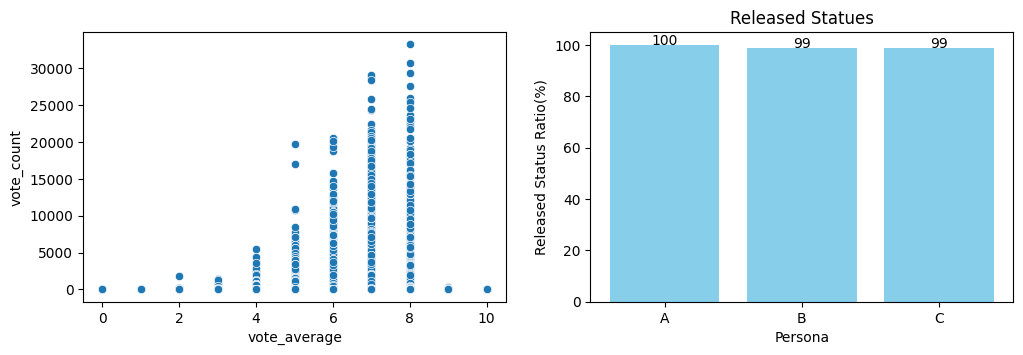

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.5))

sns.scatterplot(x="vote_average", y="vote_count", data=df, ax=ax[0])

x = ['A', 'B', 'C']
y = [a_df.status.value_counts().values[0], b_df.status.value_counts().values[0], c_df.status.value_counts().values[0]]

ax[1].bar(x, y, color='#87CEEB')
ax[1].set_title('Released Statues')
ax[1].set_xlabel('Persona')
ax[1].set_ylabel('Released Status Ratio(%)')

for i, v in enumerate(y):
    ax[1].text(i, v, str(v), ha='center')

plt.show()
# The higher the rating, the wider the number of votes. However, if the rating is extreme, the number of votes is extremely narrow
# But don't use it because it doesn't produce meaningful insights

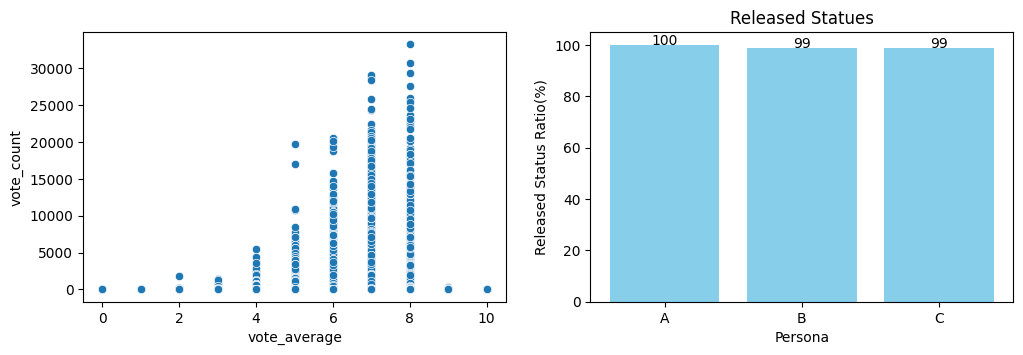

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.5))

sns.scatterplot(x="vote_average", y="vote_count", data=df, ax=ax[0])

x = ['A', 'B', 'C']
y = [a_df.status.value_counts().values[0], b_df.status.value_counts().values[0], c_df.status.value_counts().values[0]]

ax[1].bar(x, y, color='#87CEEB')
ax[1].set_title('Released Statues')
ax[1].set_xlabel('Persona')
ax[1].set_ylabel('Released Status Ratio(%)')

for i, v in enumerate(y):
    ax[1].text(i, v, str(v), ha='center')

plt.show()
# The higher the rating, the wider the number of votes. However, if the rating is extreme, the number of votes is extremely narrow
# But don't use it because it doesn't produce meaningful insights

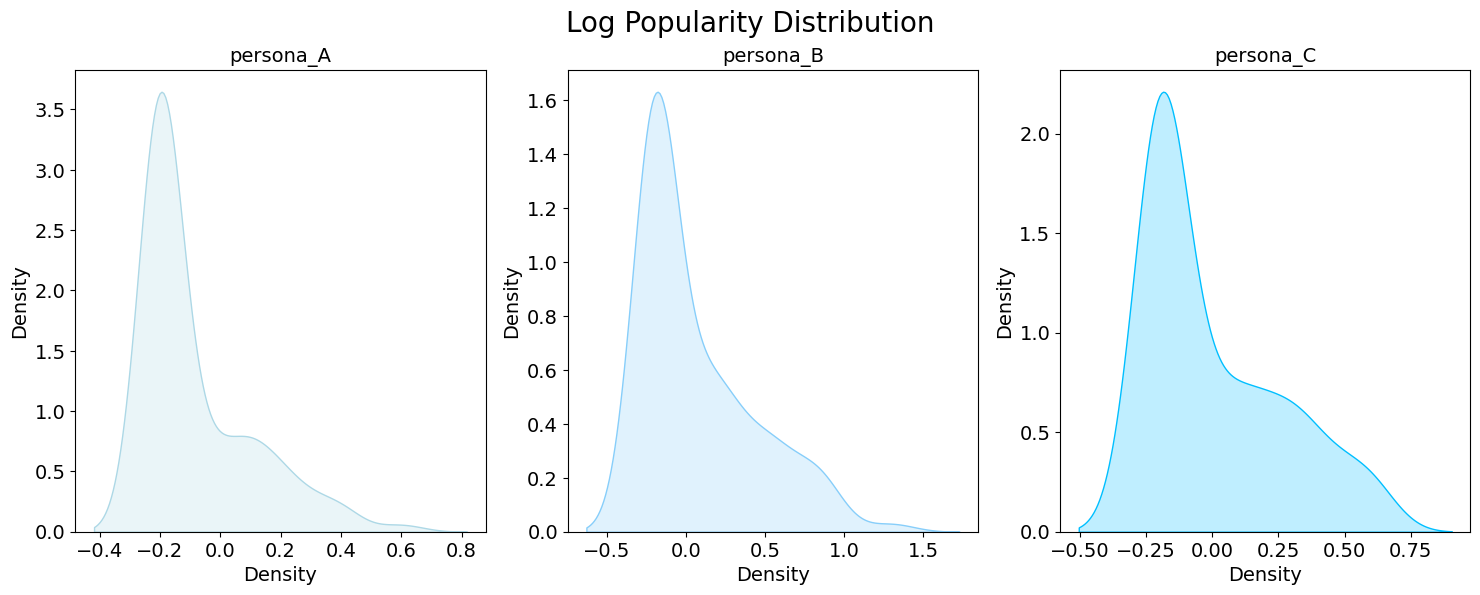

In [ ]:
# sns.set(font_scale=1.5)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.kdeplot(x='log_popularity',data =a_df , fill = True, ax= ax[0], color = '#ADD8E6')
ax[0].set_title('persona_A',fontsize = 14)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].set_ylabel("Density", fontsize=14)
ax[0].set_xlabel("Density", fontsize=14)

sns.kdeplot(x='log_popularity',data =b_df, fill = True, ax= ax[1], color = '#87CEFA')
ax[1].set_title('persona_B',fontsize = 14)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].set_ylabel("Density", fontsize=14)
ax[1].set_xlabel("Density", fontsize=14)

sns.kdeplot(x='log_popularity',data =c_df, fill = True, ax= ax[2], color = '#00BFFF')
ax[2].set_title('persona_C',fontsize = 14)
ax[2].tick_params(axis='both', labelsize=14)
ax[2].set_ylabel("Density", fontsize=14)
ax[2].set_xlabel("Density", fontsize=14)

fig.suptitle("Log Popularity Distribution", fontsize=20)


plt.show()
#Since the distribution is similar, popularity is used as a popularity variable rather than a personalization variable

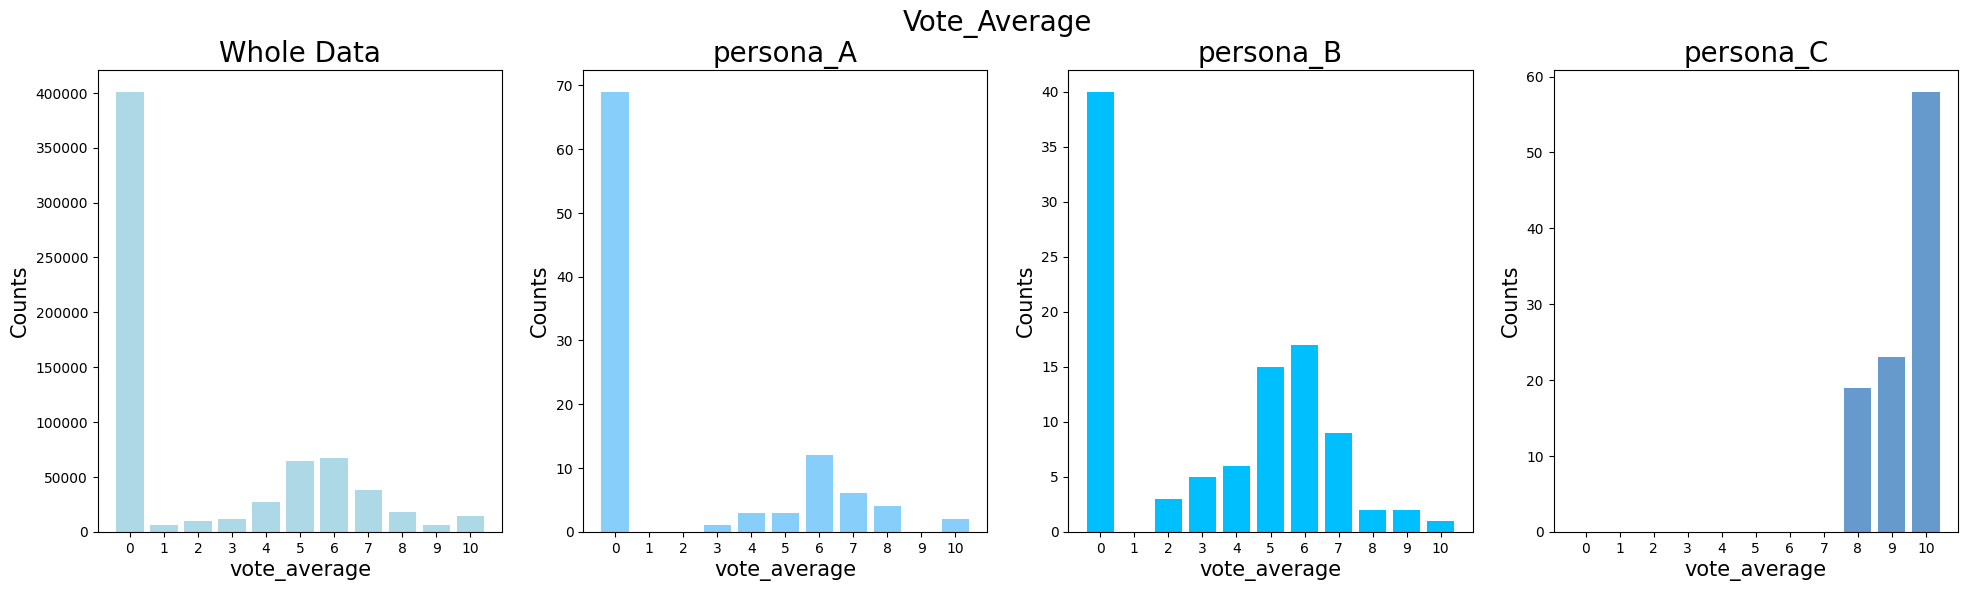

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))

a = np.array(df['vote_average'])
a_cut, bins = pd.cut(a, bins=[0,1,2,3,4,5,6,7,8,9,10,11], labels=False ,retbins=True)

# Find the number of data for each interval
counts = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    counts[i] = ((a >= bins[i]) & (a < bins[i+1])).sum()

ax[0].bar(range(len(bins) - 1) ,counts, color= '#ADD8E6') # bar plot
ax[0].set_xlabel('vote_average', fontsize = 15) # x, y labeling
ax[0].set_ylabel('Counts', fontsize = 15)
ax[0].set_title('Whole Data', fontsize = 20)
ax[0].set_xticks(range(len(bins) - 1))
ax[0].set_xticklabels(bins[:-1])

b = np.array(a_df['vote_average'])
b_cut, bins = pd.cut(b, bins=[0,1,2,3,4,5,6,7,8,9,10,11], labels=False,retbins=True)

# Find the number of data for each interval
counts = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    counts[i] = ((b >= bins[i]) & (b < bins[i+1])).sum()

ax[1].bar(range(len(bins) - 1),counts, color= '#87CEFA')
ax[1].set_xlabel('vote_average', fontsize = 15)
ax[1].set_ylabel('Counts', fontsize = 15)
ax[1].set_title('persona_A', fontsize = 20)
ax[1].set_xticks(range(len(bins) - 1))
ax[1].set_xticklabels(bins[:-1])

c = np.array(b_df['vote_average'])
c_cut, bins = pd.cut(c, bins=[0,1,2,3,4,5,6,7,8,9,10,11], labels=False,retbins=True)

# Find the number of data for each interval
counts = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    counts[i] = ((c >= bins[i]) & (c < bins[i+1])).sum()

# bar plot
ax[2].bar(range(len(bins) - 1),counts, color='#00BFFF')
ax[2].set_xlabel('vote_average', fontsize = 15)
ax[2].set_ylabel('Counts', fontsize = 15)
ax[2].set_title('persona_B', fontsize = 20)
ax[2].set_xticks(range(len(bins) - 1))
ax[2].set_xticklabels(bins[:-1])

d = np.array(c_df['vote_average'])
d_cut, bins = pd.cut(d, bins=[0,1,2,3,4,5,6,7,8,9,10,11], labels=False, retbins=True)

# Find the number of data for each interval
counts = np.zeros(len(bins) - 1)
for i in range(len(bins) - 1):
    counts[i] = ((d >= bins[i]) & (d < bins[i+1])).sum()

ax[3].bar(range(len(bins) - 1), counts, color='#6699CC')
ax[3].set_xlabel('vote_average', fontsize = 15)
ax[3].set_ylabel('Counts', fontsize = 15)
ax[3].set_title('persona_C', fontsize = 20)
ax[3].set_xticks(range(len(bins) - 1))
ax[3].set_xticklabels(bins[:-1])
fig.suptitle("Vote_Average",fontsize = 20)

plt.show()

# C preferred movies with high ratings, so those who prefer the popular -> forward correction/individual public ratio 1:2
# B has seen a lot of ratings of 4,5,6 points, so people with certain individual tastes -> Reverse correction method/individual public ratio 2:1
# A is similar to the overall distribution, so it shows a general and average person tendency -> forward correction/individual population ratio of 1:1

In [ ]:
a_df["release_month"].value_counts()

01    32
02    12
11    11
03     9
10     8
08     6
05     6
04     5
09     4
06     3
12     2
07     1
Name: release_month, dtype: int64

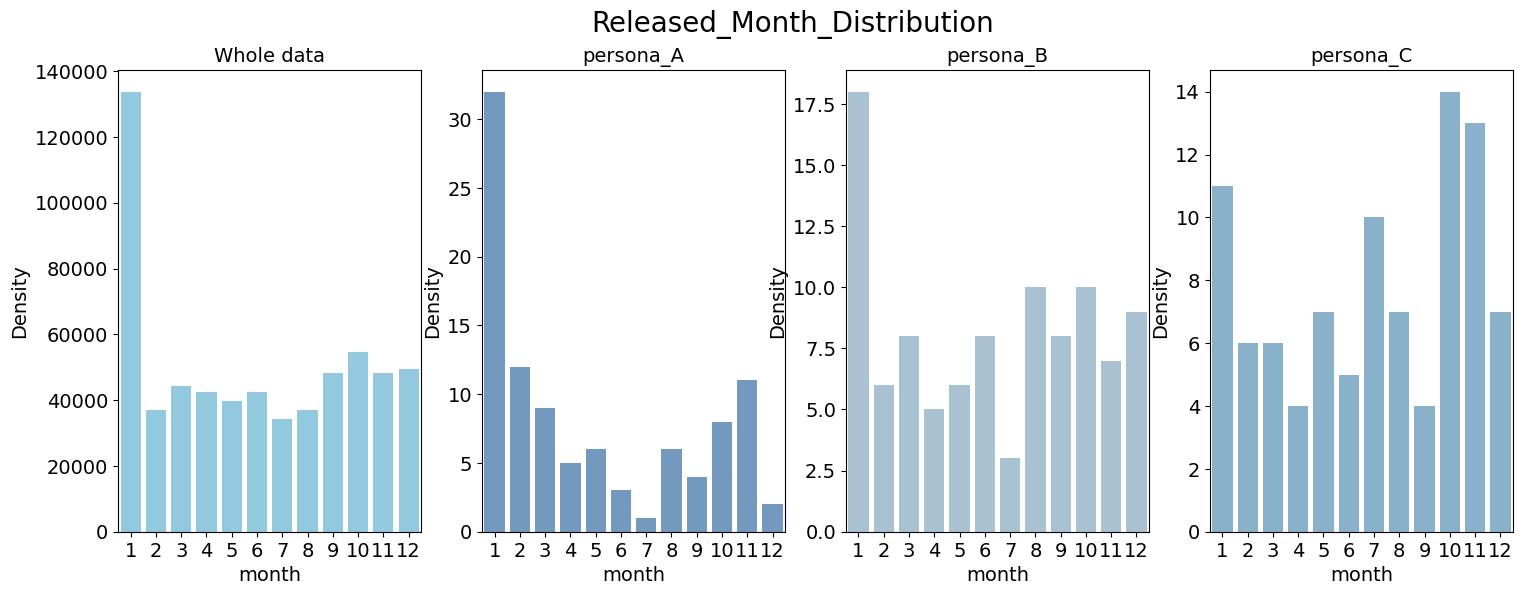

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
df["release_month"] = df["release_date"].str[5:7].values

sns.barplot(x= [int(i) for i in df["release_month"].value_counts().sort_index().index],
            y= df["release_month"].value_counts().sort_index().values,data = df ,
            fill = True, ax= ax[0], color = '#87CEEB')
ax[0].set_title('Whole data',fontsize = 14)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].set_xlabel("month", fontsize=14)
ax[0].set_ylabel("Density", fontsize=14)

sns.barplot(x= [int(i) for i in a_df["release_month"].value_counts().sort_index().index],
            y= a_df["release_month"].value_counts().sort_index().values,data =a_df ,
            fill = True, ax= ax[1], color = '#6699CC')
ax[1].set_title('persona_A',fontsize = 14)
ax[1].tick_params(axis='both', labelsize=14)
ax[1].set_xlabel("month", fontsize=14)
ax[1].set_ylabel("Density", fontsize=14)

sns.barplot(x= [int(i) for i in b_df["release_month"].value_counts().sort_index().index],
            y= b_df["release_month"].value_counts().sort_index().values,data =b_df ,
            fill = True, ax= ax[2], color = '#A2C4D9')
ax[2].set_title('persona_B',fontsize = 14)
ax[2].tick_params(axis='both', labelsize=14)
ax[2].set_xlabel("month", fontsize=14)
ax[2].set_ylabel("Density", fontsize=14)

sns.barplot(x= [int(i) for i in c_df["release_month"].value_counts().sort_index().index],
            y= c_df["release_month"].value_counts().sort_index().values,data =c_df ,
            fill = True, ax= ax[3], color = '#7FB3D5')
ax[3].set_title('persona_C',fontsize = 14)
ax[3].tick_params(axis='both', labelsize=14)
ax[3].set_xlabel("month", fontsize=14)
ax[3].set_ylabel("Density", fontsize=14)

fig.suptitle("Released_Month_Distribution", fontsize =20)
plt.show()
# There is a monthly difference, so I think we can talk about it at the time of persona definition

In [ ]:
a_recommend = df.copy()
b_recommend = df.copy()
c_recommend = df.copy()

In [ ]:
# Runtime
# Create a new df with runtime null or zero
drop_index = list(df[(df['runtime']==0) | (df['runtime'].isna())].index)
runtime_df_index = list(set(df.index) - set(drop_index))
runtime_df = df.loc[runtime_df_index]

#Divide categories of total runtime
runtime_df['runtime_catagory'] = 0
runtime_df.loc[(runtime_df["runtime"]>=1)&(runtime_df["runtime"]<=30),'runtime_catagory'] = '1~30 min'
runtime_df.loc[(runtime_df["runtime"]>30)&(runtime_df["runtime"]<=60),'runtime_catagory'] = '30~60 min'
runtime_df.loc[(runtime_df["runtime"]>60)&(runtime_df["runtime"]<=90),'runtime_catagory'] = '60~90 min'
runtime_df.loc[(runtime_df["runtime"]>90)&(runtime_df["runtime"]<=120),'runtime_catagory'] = '90~120 min'
runtime_df.loc[(runtime_df["runtime"]>120)&(runtime_df["runtime"]<=150),'runtime_catagory'] = '120~150 min'
runtime_df.loc[(runtime_df["runtime"]>150)&(runtime_df["runtime"]<=180),'runtime_catagory'] = '150~180 min'
runtime_df.loc[(runtime_df["runtime"]>180)&(runtime_df["runtime"]<=210),'runtime_catagory'] = '180~210 min'
runtime_df.loc[runtime_df["runtime"]>210,'runtime_catagory'] = '210 min~'

# Define each persona by approaching it correctly
a_runtime_df = runtime_df[runtime_df['id'].isin(persona_A)]
b_runtime_df = runtime_df[runtime_df['id'].isin(persona_B)]
c_runtime_df = runtime_df[runtime_df['id'].isin(persona_C)]

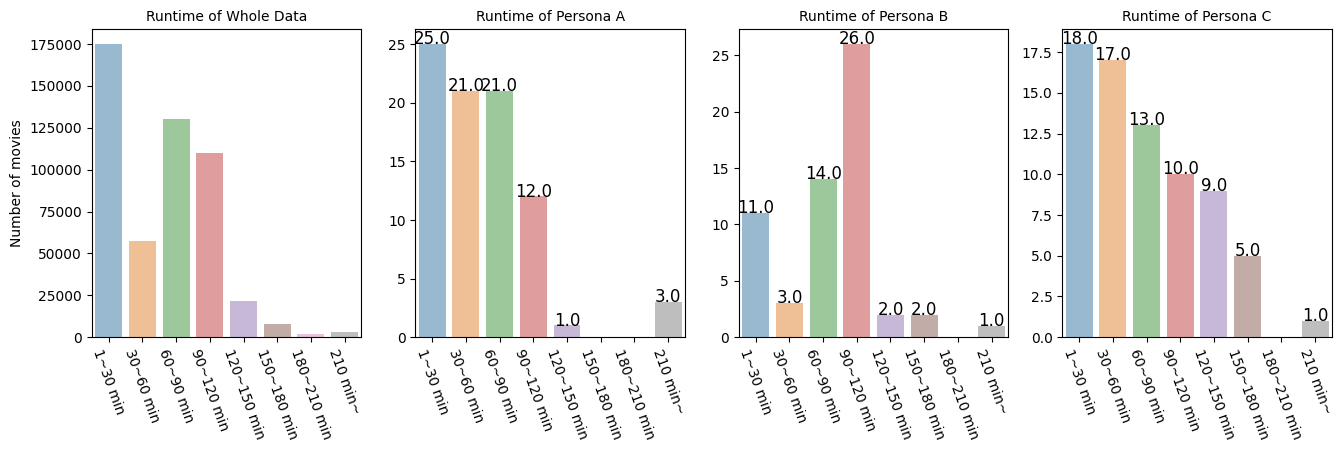

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
pastel_rainbow_colors = ["#ffb3ba", "#ffdfba", "#ffffba", "#baffc9", "#bae1ff", "#ffb6d9"]
# plt.rcParams.update({'font.size': 10})

pastel_rainbow_colors = ["#ffb3ba", "#ffdfba", "#ffffba", "#baffc9", "#bae1ff", "#ffb6d9"]

# Visualize Full Data Runtime
order = list(runtime_df.sort_values(by = 'runtime')['runtime_catagory'].unique())
movies_by_runtime = runtime_df['runtime_catagory'].value_counts().reindex(order)
sns.barplot(x=movies_by_runtime.index,y=movies_by_runtime.values,alpha=0.5, ax=ax[0], order=order)
ax[0].set_title('Runtime of Whole Data',fontsize = 10)
ax[0].set_ylabel('Number of movies')
ax[0].set_xticklabels(order, rotation=-70)

# Persona A Runtime Visualization
a_movies_by_runtime = a_runtime_df['runtime_catagory'].value_counts().reindex(order)
sns.barplot(x=a_movies_by_runtime.index,y=a_movies_by_runtime.values,alpha=0.5, ax=ax[1], order=order)
ax[1].set_title('Runtime of Persona A',fontsize = 10)
ax[1].set_xticklabels(order, rotation=-70)
for i, v in enumerate(list(a_movies_by_runtime.values)):
    ax[1].text(i, v, str(v), ha='center', fontsize = 12)

#Persona B runtime Visualization
b_movies_by_runtime = b_runtime_df['runtime_catagory'].value_counts().reindex(order)
sns.barplot(x=b_movies_by_runtime.index,y=b_movies_by_runtime.values,alpha=0.5, ax= ax[2], order = order)
ax[2].set_title('Runtime of Persona B',fontsize = 10)
ax[2].set_xticklabels(order,rotation = -70)
for i, v in enumerate( list(b_movies_by_runtime.values)):
    ax[2].text(i, v, str(v), ha='center', fontsize = 12)

#Persona C runtime Visualization
c_movies_by_runtime = c_runtime_df['runtime_catagory'].value_counts().reindex(order)
sns.barplot(x=c_movies_by_runtime.index, y=c_movies_by_runtime.values, alpha=0.5,
            ax= ax[3], order = order
           )
ax[3].set_title('Runtime of Persona C',fontsize = 10)
ax[3].set_xticklabels(order,rotation = -70)
for i, v in enumerate(list(c_movies_by_runtime.values)):
    ax[3].text(i, v, str(v), ha='center', fontsize = 12)

plt.show()
# A and C tend to like short movies, even compared to the whole, and accordingly, they are likely to be impatient and impatient
# B, on the other hand, prefers longer movies than the overall distribution -> more likely to be patient middle-aged

<ipython-input-66-e7b1c576e028>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-66-e7b1c576e028>:38: UserWarning:

FixedFormatter should only be used together with FixedLocator



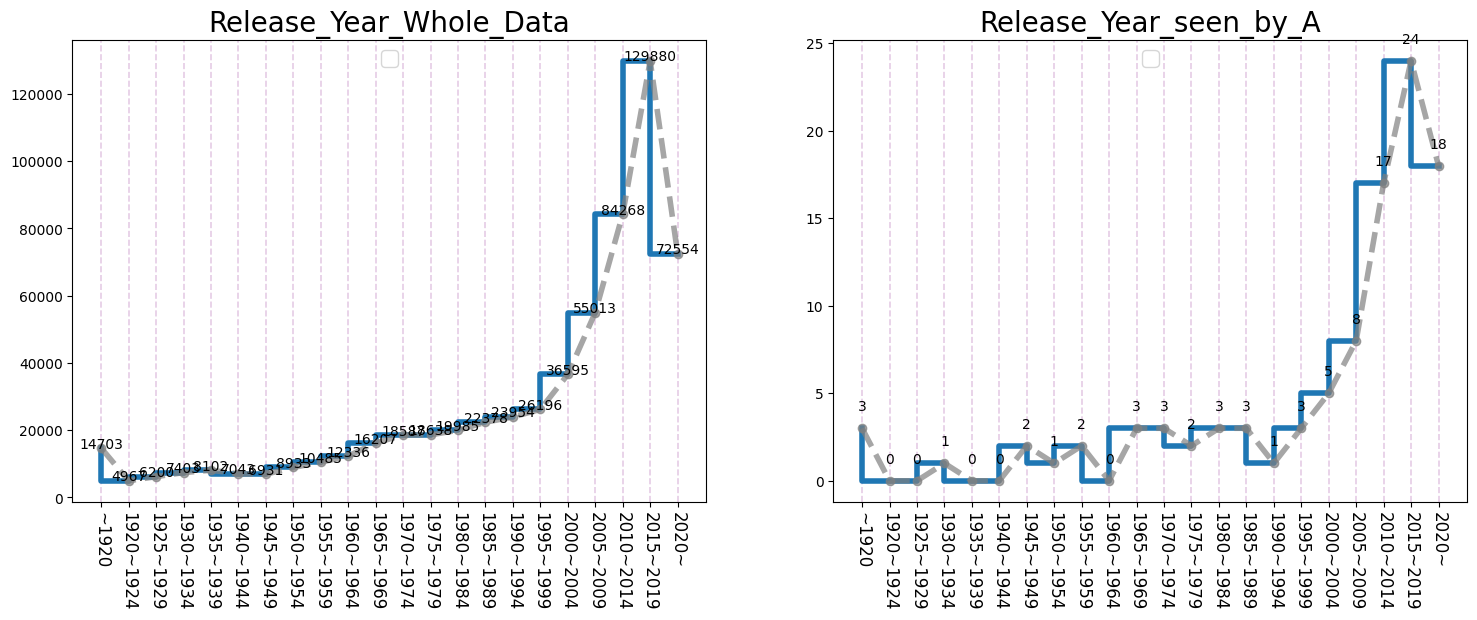

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

list_df = []
a = df[df["release_year"] < 1920]['id'].count() - df[df["release_year"] == 0]['id'].count()
list_df.append(a)
for i in np.arange(1920, 2020, 5):
    list_df.append(df[(df["release_year"] >= i) & (df["release_year"] < i + 5)]['id'].count())
b = df[df["release_year"] >= 2020]['id'].count()
list_df.append(b)

x= ["~1920", "1920~1924","1925~1929","1930~1934","1935~1939","1940~1944","1945~1949","1950~1954","1955~1959","1960~1964","1965~1969",'1970~1974','1975~1979','1980~1984','1985~1989','1990~1994','1995~1999','2000~2004','2005~2009','2010~2014','2015~2019','2020~']
y = list_df
ax[0].set_title("Release_Year_Whole_Data",fontsize = 20)
ax[0].step(x, y, lw = 4)
ax[0].plot(x, y,  "o--", color = '#808080', alpha = 0.7, linewidth=4)
ax[0].grid(axis ='x',color = 'purple', alpha = 0.2, ls = '--', lw =1.2)
ax[0].set_xticklabels(x, fontsize=12, rotation = 270)
ax[0].legend(loc = "upper center", fontsize = 15)

for idx, txt in enumerate(y):
    ax[0].text(x[idx], y[idx] + 1.0 , txt, ha = 'center', color = 'black')


list_A = []
a = a_df[a_df["release_year"] < 1920]['id'].count() - a_df[a_df["release_year"] == 0]['id'].count()
list_A.append(a)
for i in np.arange(1920, 2020, 5):
    list_A.append(a_df[(a_df["release_year"] >= i) & (a_df["release_year"] < i + 5)]['id'].count())
b = a_df[a_df["release_year"] >= 2020]['id'].count()
list_A.append(b)

x= ["~1920", "1920~1924","1925~1929","1930~1934","1935~1939","1940~1944","1945~1949","1950~1954","1955~1959","1960~1964","1965~1969",'1970~1974','1975~1979','1980~1984','1985~1989','1990~1994','1995~1999','2000~2004','2005~2009','2010~2014','2015~2019','2020~']
y = list_A
ax[1].set_title("Release_Year_seen_by_A",fontsize = 20)
ax[1].step(x, y, lw = 4)
ax[1].plot(x, y,  "o--", color = '#808080', alpha = 0.7, linewidth=4)
ax[1].grid(axis ='x',color = 'purple', alpha = 0.2, ls = '--', lw =1.2)
ax[1].set_xticklabels(x, fontsize=12, rotation = 270)
ax[1].legend(loc = "upper center", fontsize = 15)

for idx, txt in enumerate(y):
    ax[1].text(x[idx], y[idx] + 1.0 , txt, ha = 'center', color = 'black')
# A has no different characteristics compared to the whole

In [ ]:
A_count = dict(Counter(a_df['original_language'].values.tolist()))
A_count = dict(sorted(A_count.items(), key=lambda x: x[1], reverse=True))
A_count

{'en': 42,
 'es': 10,
 'fr': 7,
 'pt': 6,
 'cs': 4,
 'de': 4,
 'zh': 3,
 'sv': 3,
 'nl': 2,
 'cn': 2,
 'sl': 2,
 'it': 2,
 'ja': 1,
 'uk': 1,
 'ru': 1,
 'eu': 1,
 'hr': 1,
 'ca': 1,
 'fi': 1,
 'et': 1,
 'ko': 1,
 'tl': 1,
 'pl': 1,
 'el': 1,
 'ar': 1}

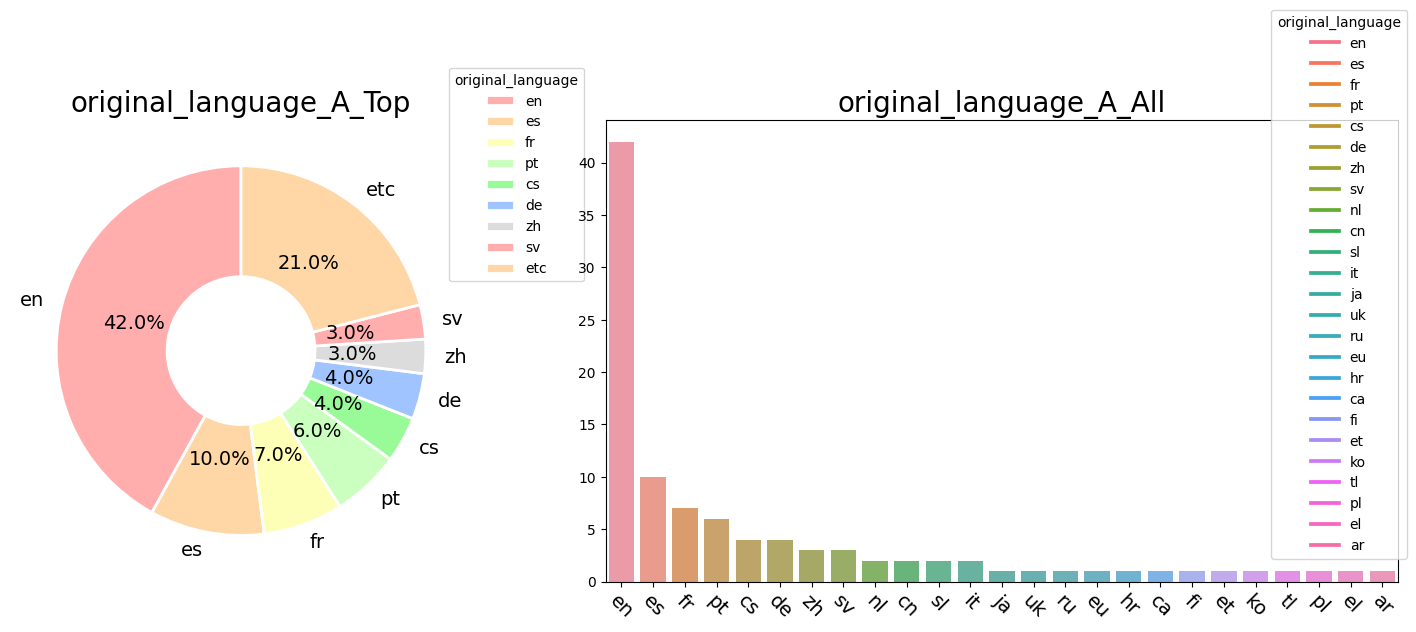

In [ ]:
# Select top language based on at least 2 times
top_genres_A = dict()
etc = 0 ; thres = 2
for key in A_count:
    if A_count[key] > thres:
        top_genres_A[key] = A_count[key]
    else :
        etc += A_count[key]
# top_genres_B[f'under {thres*100}%'] = etc
top_genres_A['etc'] = etc


# custum piechart
def custom_autopct(pct):
    return('%.1f%%' %pct) if True else '' #Change it later and use it

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), gridspec_kw={'width_ratios': [3, 5]})

wedgeprops = {'width' : 0.6, 'edgecolor' : 'w', 'linewidth': 2}
colors = ['#ffadad', '#ffd6a5', '#fdffb6','#caffbf', '#98fb98', '#a0c4ff','#dcdcdc']
ax[0].pie(top_genres_A.values(), labels = top_genres_A.keys(),  autopct= custom_autopct,
        startangle=90, wedgeprops = wedgeprops,colors = colors, textprops={'fontsize': 14})
ax[0].legend(title = "original_language", loc = (0.95,0.65))
ax[0].set_title("original_language_A_Top", fontsize = 20)


# bar chart
x = list(A_count.keys())
y = list(A_count.values())

palette = sns.color_palette("husl", len(x))
sns.barplot(x=x,y=y, alpha=0.8, ax= ax[1], palette= palette)
# ax[1].set_xlabel("언어")
ax[1].set_title('original_language_A_All', fontsize = 20)
ax[1].set_xticklabels(x,rotation = -45)
ax[1].tick_params(axis='x', labelsize=14)

legend = ax[1].legend(x, title = "original_language", loc = (0.84,0.05)) # Import Legend Objects
lines = legend.get_lines()
for i in range(len(lines)):
    lines[i].set_color(palette[i]) # Setting the color of a legend item

plt.show()

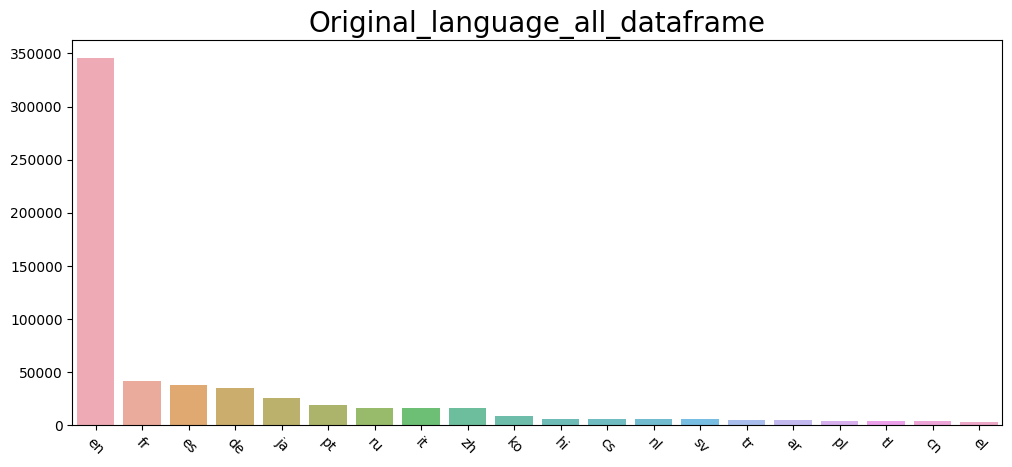

In [ ]:
df_count = dict(Counter(df['original_language'].values.tolist()))
df_count = dict(sorted(df_count.items(), key=lambda x: x[1], reverse=True)[:20])

x = list(df_count.keys())
y = list(df_count.values())
plt.figure(figsize=(12,5))
sns.barplot(x=x,y=y, alpha=0.8)
plt.title('Original_language_all_dataframe', fontsize = 20)
plt.xticks(rotation = -45)
plt.show()

In [ ]:
temp_genre = [word for words in a_df['genres'].values for word in words]
a_df_genre = dict(Counter(temp_genre))
a_df_genre = dict(sorted(a_df_genre.items(), key=lambda x: x[1], reverse=True))
a_df_genre

{'Documentary': 100}

In [ ]:
from itertools import chain

doc_related = dict()
for words in ['Documentary']:
    has = df['genres'].apply(lambda x: words in x)
    doc_related = list(chain(*df[has].genres.values))
    doc_related = dict(Counter(doc_related))
    doc_related = dict(sorted(doc_related.items(), key=lambda x: x[1], reverse=True))

doc_related

{'Documentary': 105552,
 'Music': 6165,
 'History': 3902,
 'Drama': 2415,
 'TV Movie': 2035,
 'Comedy': 1608,
 'Animation': 1361,
 'War': 1254,
 'Adventure': 743,
 'Family': 671,
 'Crime': 612,
 'Horror': 471,
 'Action': 428,
 'Science Fiction': 267,
 'Mystery': 250,
 'Fantasy': 197,
 'Romance': 162,
 'Thriller': 115,
 'Western': 69}

In [ ]:
doc_related_copy = doc_related.copy()
del doc_related_copy['Documentary']

temp_df = pd.DataFrame(doc_related_copy, index = ['freq']).T.reset_index()
temp_df['label'] = temp_df['index'] + '<br>' + temp_df['freq'].astype(str)

fig = px.treemap(temp_df, path=[px.Constant('Related Genres with Documentary'), 'label'], values='freq',
                 color = 'freq',color_continuous_scale='RdBu',
                color_continuous_midpoint=np.average(temp_df['freq'], weights=temp_df['freq']))
#fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=650,
    height=300,
    margin=dict(l=0, r=0, t=50, b=0)
)
fig.update_traces(textfont=dict(size=20),root_color="white")
fig.show()

In [ ]:
A_list = [word for words in a_df['credits'].values for word in words]
A_credits = dict(Counter(A_list))
A_credits = dict(sorted(A_credits.items(), key=lambda x: x[1], reverse=True))
del A_credits['']
A_credits
# A_credits : dict form
credit_map = pd.DataFrame(A_credits, index = ['A_CREDITS_COUNT'])
display(credit_map)

colorscale = [
    [0, '#AEC6CF'],
    [1, '#AEC6CF']
]
x =  credit_map.columns.tolist()
y = credit_map.index.tolist()

annotations = []
for c in range(credit_map.shape[1]):
    if c == int((credit_map.shape[1])/2):
        annotations.append(go.layout.Annotation(text=str(credit_map.iloc[0][c]), x=x[c], y=y[0],
                                         font={'size': 12, 'color': 'white'}, showarrow=False))
    else:
        annotations.append(go.layout.Annotation(text= '', x=x[c], y=y[0],
                                         font={'size': 10, 'color': 'white'}, showarrow=False))
layout = go.Layout(annotations=annotations, width=800, height=200,
                   coloraxis_colorbar=dict(thickness=0), coloraxis_showscale=False
                  ,margin=dict(l=0, r=0, t=0, b=180))

fig = go.Figure(data=go.Heatmap(z= credit_map,
                                x= credit_map.columns.tolist(), # text_auto=True,
                                y= credit_map.index.tolist(),
                                colorscale=colorscale,text=list(credit_map.values), showscale=False
                                ),layout = layout)


fig.show()

Chu Tien  Wahlforss  Robert Steffey  Freddie Rodriguez  \
A_CREDITS_COUNT         3          3               1                  1   

                 Deliris Vasquez  Oliver Platt  Steve Austin  Ric Flair  \
A_CREDITS_COUNT                1             1             1          1   

                 Booker Huffman  Mark Calaway  ...  Friedemann Beyer  \
A_CREDITS_COUNT               1             1  ...                 1   

                 Olaf Legenbauer  Rolf Giesen  Per Anders Fogelström  \
A_CREDITS_COUNT                1            1                      1   

                 Finn Zetterholm  Per Kågeson  Irma Jensing  Pontus Hulten  \
A_CREDITS_COUNT                1            1             1              1   

                 Ejnar Haglund  Peter Celsing  
A_CREDITS_COUNT              1              1  

[1 rows x 194 columns]

In [ ]:
a_df_list = [word for words in a_df['keywords'].values for word in words]
a_df_keywords = dict(Counter(a_df_list))
a_df_keywords = dict(sorted(a_df_keywords.items(), key=lambda x: x[1], reverse=True))
del a_df_keywords['']
a_df_keywords

{'woman director': 3,
 'biography': 2,
 'refugee': 2,
 'short film': 2,
 'new jersey': 1,
 'lockdown': 1,
 'covid': 1,
 '19': 1,
 'pornography': 1,
 'sexuality': 1,
 'sex education': 1,
 'wolf': 1,
 'nature': 1,
 'sports': 1,
 'base jumping': 1,
 'africa': 1,
 'independence': 1,
 'serbia': 1,
 'poverty': 1,
 'football (soccer)': 1,
 'malaria': 1,
 'south sudan': 1,
 'football (soccer) coach': 1,
 'child abuse': 1,
 'monk': 1,
 'volunteer': 1,
 'war zone': 1,
 'volunteering': 1,
 'estonia': 1,
 'donbass war': 1,
 'russian invasion of ukraine': 1,
 '2010s': 1,
 'ukraine': 1,
 'animated scene': 1,
 'unsolved mystery': 1,
 'australian outback': 1,
 'hong kong': 1,
 'documentary filmmaking': 1,
 'taboo sex': 1,
 'popular festivity': 1,
 'martial arts': 1,
 'burma': 1,
 'combat sports': 1,
 'penitentiary': 1,
 "women's prison": 1,
 'bookshop': 1,
 'franco regime (francoism)': 1,
 'extortion': 1,
 'eta terrorist gang': 1,
 'terrorism': 1,
 'cinema history': 1,
 'cultural heritage': 1,
 'women

In [ ]:
from itertools import chain

a_key = set(a_df_keywords.keys())
a_related = pd.DataFrame(index=list(a_key), columns=list(a_key))
a_related.loc[:, :] = 0

# 가공
for words in list(a_key):
    has = df['keywords'].apply(lambda x: words in x)
    result = set(list(chain(*df[has].keywords.values)))
    result.discard(words)
    result = list(result & a_key)
    a_related.loc[words,result] = 1
display(a_related)
A_heatmap = a_related.copy()

a_related['related_rank'] = a_related.sum(axis = 1)
a_related = a_related.sort_values(by='related_rank', ascending=False)

temp_join = pd.DataFrame(a_df_keywords, index = ['freq']).T
temp_join
a_related = a_related.join(temp_join, how='inner')
a_related['keyword_score'] = a_related['freq'] * a_related['related_rank']

display(a_related)

sexuality sex education burma estonia  \
sexuality                           0             1     0       0   
sex education                       1             0     0       0   
burma                               0             0     0       0   
estonia                             0             0     0       0   
black and white                     0             1     0       0   
...                               ...           ...   ...     ...   
taboo sex                           1             1     0       0   
russian invasion of ukraine         0             0     0       1   
football (soccer)                   0             0     0       0   
immigration                         0             0     0       0   
covid                               0             0     0       0   

                            black and white child abuse aviation  \
sexuality                                 0           1        0   
sex education                             1           0        0   
burma                                     0           0        0   
estonia                                   0           0        0   
black and white                           0           0        0   
...                                     ...         ...      ...   
taboo sex                                 0           0        0   
russian invasion of ukraine               0           0        0   
football (soccer)                         0           0        0   
immigration                               0           0        0   
covid                                     1           0        0   

                            women in film women's prison volunteering  ...  \
sexuality                               1              0            0  ...   
sex education                           0              0            0  ...   
burma                                   0              0            0  ...   
estonia                                 0              0            1  ...   
black and white                         0              0            0  ...   
...                                   ...            ...          ...  ...   
taboo sex                               0              0            0  ...   
russian invasion of ukraine             0              0            1  ...   
football (soccer)                       0              0            0  ...   
immigration                             0              0            0  ...   
covid                                   0              0            0  ...   

                            war zone homeopathy new york city 2010s  \
sexuality                          0          0             1     0   
sex education                      0          0             1     0   
burma                              0          0             0     0   
estonia                            1          0             0     1   
black and white                    0          0             1     0   
...                              ...        ...           ...   ...   
taboo sex                          0          0             0     0   
russian invasion of ukraine        1          0             0     1   
football (soccer)                  0          0             1     1   
immigration                        0          0             1     0   
covid                              0          0             1     0   

                            popular festivity taboo sex  \
sexuality                                   0         1   
sex education                               0         1   
burma                                       0         0   
estonia                                     0         0   
black and white                             0         0   
...                                       ...       ...   
taboo sex                                   0         0   
russian invasion of ukraine                 0         0   
football (soccer)                           0         0   
im

sexuality sex education burma estonia black and white  \
short film                1             1     1       0               1   
woman director            1             1     1       1               1   
lgbt                      1             0     1       1               1   
biography                 1             1     0       0               1   
new york city             1             1     0       0               1   
...                     ...           ...   ...     ...             ...   
roma                      0             0     0       0               0   
popular festivity         0             0     0       0               0   
believe                   0             0     0       0               0   
homeopathy                0             0     0       0               0   
worship                   0             0     0       0               0   

                  child abuse aviation women in film women's prison  \
short film                  1        0             1              1   
woman director              1        1             1              1   
lgbt                        1        0             0              1   
biography                   1        1             0              0   
new york city               0        1             0              1   
...                       ...      ...           ...            ...   
roma                        0        0             0              0   
popular festivity           0        0             0              0   
believe                     0        0             0              0   
homeopathy                  0        0             0              0   
worship                     0        0             0              0   

                  volunteering  ... 2010s popular festivity taboo sex  \
short film                   0  ...     1                 1         1   
woman director               0  ...     1                 0         0   
lgbt                         0  ...     1                 0         1   
biography                    0  ...     1                 0         0   
new york city                0  ...     0                 0         0   
...                        ...  ...   ...               ...       ...   
roma                         0  ...     0                 0         0   
popular festivity            0  ...     0                 0         0   
believe                      0  ...     0                 0         0   
homeopathy                   0  ...     0                 0         0   
worship                      0  ...     0                 0         0   

                  russian invasion of ukraine football (soccer) immigration  \
short film                                  1                 1           1   
woman director                              0                 1           1   
lgbt                                        0                 1           1   
biography                                   0                 1           0   
new york city                               0                 1           1   
...                                       ...               ...         ...   
roma                                        0                 0           0   
popular festivity                           0                 0           0   
believe                                     0                 0           0   
homeopathy                                  0                 0           0   
worship                                     0                 0           0   

                  covid related_rank freq keyword_score  
short film            1         58.0    2         116.0  
woman director        1         56.0    3         168.0  
lgbt                  1         42.0    1          42.0  
biography             0         41.0    2          82.0  
new york city         1         38.0    1          38.0  
...                 ...          ...  ...           ...  
roma                  0         

In [ ]:
colorscale = [
    [0, "#f7e6d2"],
    [0.2, "#f1c6a6"],
    [0.4, "#eaa783"],
    [0.6, "#e2856e"],
    [0.8, "#d15e5a"],
    [1, "#b12c41"],
]

# Calculate the maximum and minimum values for each column
max_vals = A_heatmap.max().max()
min_vals = A_heatmap.min().min()

# Min-Max Scaling
A_heatmap = (A_heatmap - min_vals) / (max_vals - min_vals)
fig = go.Figure(data=go.Heatmap(z= A_heatmap,
                                x= A_heatmap.index.tolist(),
                                y= A_heatmap.columns.tolist(),
                                colorscale='YlGnBu'))
fig.update_layout(
    title={
        'text':'Keyword Network heatmap_A',
        'x': 0.55,
        'y': 0.96
    },
    margin=dict(l=0, r=0, t=50, b=0)
    #,xaxis=dict(title='X Axis')
    #,yaxis=dict(title='Keyw')
)
fig.update_layout(width=600, height=600)

fig.show()

In [ ]:
keyword_dict = dict(a_related['keyword_score'])
a_recommend['keyword_score'] = 0
for keyword in keyword_dict:
    a_recommend.loc[a_recommend['keywords'].apply(lambda x: keyword in x), 'keyword_score'] += keyword_dict[keyword]

a_recommend['langu_score'] = a_recommend['original_language'].apply(lambda x: A_count.get(x, 0))

a_recommend['genre_score'] = 0
for genre in doc_related:
    a_recommend.loc[a_recommend['genres'].apply(lambda x: genre in x), 'genre_score'] += doc_related[genre]
a_recommend

id                                             title  \
0       615656                                 Meg 2: The Trench   
1       758323                               The Pope's Exorcist   
2       667538                  Transformers: Rise of the Beasts   
3       640146                 Ant-Man and the Wasp: Quantumania   
4       677179                                         Creed III   
...        ...                                               ...   
662078  741629                                        Blitzkrieg   
662079  430327  Con aura senz'aura. Viaggio ai confini dell'arte   
662080  633623                                     Midsommarvaka   
662081  294742                                 Gospođa- Slobodan   
662082  968161                                     Gising Sining   

                                      genres original_language  popularity  \
0          [Action, Science Fiction, Horror]                en    8763.998   
1                [Horror, Mystery, Thriller]                en    5953.227   
2       [Action, Adventure, Science Fiction]                en    5409.104   
3       [Action, Adventure, Science Fiction]                en    4425.387   
4                            [Drama, Action]                en    3994.342   
...                                      ...               ...         ...   
662078                              [Horror]                es       0.600   
662079                                    []                it       0.600   
662080                               [Music]                xx       0.600   
662081                                    []                en       0.600   
662082                                    []                tl       0.600   

                                     production_companies release_date  \
0       Apelles Entertainment-Warner Bros. Pictures-di...   2023-08-02   
1       Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...   2023-04-05   
2       Skydance-Paramount-di Bonaventura Pictures-Bay...   2023-06-06   
3                  Marvel Studios-Kevin Feige Productions   2023-02-15   
4       Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...   2023-03-01   
...                                                   ...          ...   
662078                                                      2020-10-01   
662079                                                      2003-02-02   
662080                                         SF Studios   1947-12-26   
662081                                                             NaN   
662082                                          Studio RD          NaN   

             budget      revenue  runtime  ... vote_average  vote_count  \
0       129000000.0  352056482.0    116.0  ...            7      1365.0   
1        18000000.0   65675816.0    103.0  ...            7       545.0   
2       200000000.0  407045464.0    127.0  ...            7      1007.0   
3       200000000.0  475766228.0    125.0  ...            6      2811.0   
4        75000000.0  269000000.0    116.0  ...            7      1129.0   
...             ...          ...      ...  ...          ...         ...   
662078          0.0          0.0      8.0  ...            6         1.0   
662079          0.0          0.0      NaN  ...            0         0.0   
662080          0.0          0.0     11.0  ...            0         0.0   
662081          0.0          0.0      5.0  ...            0         0.0   
662082          0.0          0.0     19.0  ...            0         0.0   

                                                  credits  \
0       [Jason Statham, Wu Jing, Shuya Sophia Cai, Ser...   
1       [Russell Crowe, Daniel Zovatto, Alex Essoe, Fr...   
2       [Anthony Ramos, Dominique Fishback, Luna Laure...   
3       [Paul Rudd, Evangeline Lilly, Jonathan Majors,...   
4       [Michael B. Jordan, Tessa Thompson, Jonathan M...   
...                                                   ...   
662078                                   

In [ ]:
a_score = a_recommend[['id', 'log_popularity','vote_average','langu_score','genre_score','keyword_score']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(a_score.iloc[:,1:])
scaled_a_score = pd.DataFrame(X_scaled, columns=a_score.iloc[:,1:].columns, index = a_score['id'])
scaled_a_score

log_popularity  vote_average  langu_score  genre_score  keyword_score
id                                                                           
615656        1.000000           0.7     1.000000     0.009411       0.000000
758323        0.975610           0.7     1.000000     0.006748       0.000000
667538        0.951220           0.7     1.000000     0.011607       0.000000
640146        0.926829           0.6     1.000000     0.011607       0.000000
677179        0.926829           0.7     1.000000     0.022948       0.088235
...                ...           ...          ...          ...            ...
741629        0.000000           0.6     0.238095     0.003802       0.000000
430327        0.000000           0.0     0.047619     0.000000       0.000000
633623        0.000000           0.0     0.000000     0.049761       0.284314
294742        0.000000           0.0     1.000000     0.000000       0.000000
968161        0.000000           0.0     0.023810     0.000000       0.000000

[662079 rows x 5 columns]

In [ ]:
scaled_a_score['total_score'] = ((scaled_a_score['log_popularity']+scaled_a_score['vote_average'])/2*3)+\
                                scaled_a_score['langu_score']+ scaled_a_score['genre_score']+ scaled_a_score['keyword_score']
scaled_a_score = scaled_a_score.sort_values(by='total_score', ascending=False)
scaled_a_score = scaled_a_score[~scaled_a_score.index.isin(a_df.id.tolist())]
display(scaled_a_score)
print(set(a_df.id.values.tolist()) & set(scaled_a_score.index.tolist())) #No intersection
a_radar = scaled_a_score.iloc[:3,:5]
a_radar.reset_index(inplace = True)
a_radar_ranking = a_radar.id.values
display(a_radar)

log_popularity  vote_average  langu_score  genre_score  keyword_score  \
id                                                                              
448387        0.609756           0.9          1.0     0.851975       0.000000   
31225         0.292683           0.8          1.0     0.851975       0.607843   
522529        0.219512           1.0          1.0     0.851975       0.411765   
861130        0.390244           1.0          1.0     0.851975       0.147059   
230864        0.170732           0.9          1.0     0.851975       0.612745   
...                ...           ...          ...          ...            ...   
738871        0.000000           0.0          0.0     0.000000       0.000000   
887061        0.000000           0.0          0.0     0.000000       0.000000   
864406        0.000000           0.0          0.0     0.000000       0.000000   
859133        0.000000           0.0          0.0     0.000000       0.000000   
577409        0.000000           0.0          0.0     0.000000       0.000000   

        total_score  
id                   
448387     4.116609  
31225      4.098842  
522529     4.093008  
861130     4.084399  
230864     4.070817  
...             ...  
738871     0.000000  
887061     0.000000  
864406     0.000000  
859133     0.000000  
577409     0.000000  

[661979 rows x 6 columns]

set()


id  log_popularity  vote_average  langu_score  genre_score  \
0  448387        0.609756           0.9          1.0     0.851975   
1   31225        0.292683           0.8          1.0     0.851975   
2  522529        0.219512           1.0          1.0     0.851975   

   keyword_score  
0       0.000000  
1       0.607843  
2       0.411765

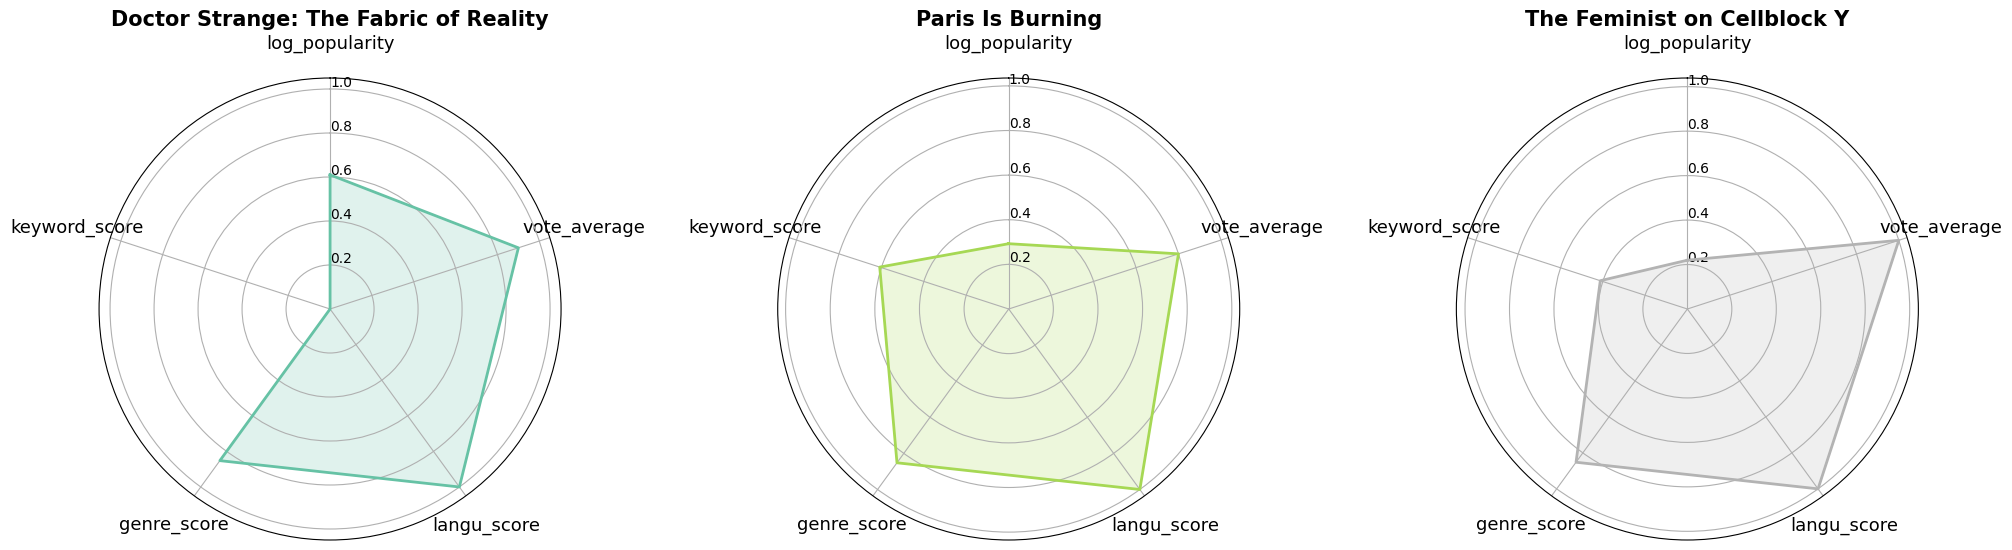

In [ ]:
labels = a_radar.iloc[:,1:].columns
num_labels = len(labels)

angles = [x/float(num_labels)*(2*np.pi) for x in range(num_labels)]## angular equivocal point
angles += angles[:1] ## Add a starting point because you need to come back to the starting point

my_palette = plt.get_cmap("Set2", len(a_radar.iloc[:,1:].index))
a_radar = a_radar.set_index('id').loc[a_radar_ranking].reset_index()
# 서브플롯 설정
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,6), subplot_kw=dict(polar=True))

# 레이더 차트 그리기
for i, row in a_radar.iterrows():
    color = my_palette(i)
    data = row[1:].tolist()
    data += data[:1]

    ax = axes[i]
    ax.set_theta_offset(np.pi / 2) ## the starting point
    ax.set_theta_direction(-1) ## Direction drawn Clockwise

    ax.set_rlabel_position(0) ## Set radial axis tick label angle (in degrees)

    ax.plot(angles, data, color=color, linewidth=2,
            linestyle='solid', label=df[df['id'] == row.id].title.values[0]) ## Radar Chart Output
    ax.fill(angles, data, color=color, alpha=0.2) ## Fill the inside of the figure with color.

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=13) ## Angle axis tick label
    ax.tick_params(axis='x', which='major', pad=15) ## Give a space between each axis and the scale.
    # ax.set_rlim(0, 10) ## Set radius axis range

    ax.set_title(df[df['id'] == row.id].title.values[0], fontsize=15, fontweight='bold')

# Legend Settings
# fig.legend(title = "Recommend_Movie", loc=(0.75,0.7), fontsize=15, title_fontsize=18)
plt.subplots_adjust(wspace=0.35)

plt.show()

In [ ]:
top_number = 3
a_recommend_id = scaled_a_score.index.tolist()[:top_number]
df[df['id'].isin(a_recommend_id)]

id                                  title         genres  \
143    448387  Doctor Strange: The Fabric of Reality  [Documentary]   
15975   31225                       Paris Is Burning  [Documentary]   
36163  522529            The Feminist on Cellblock Y  [Documentary]   

      original_language  popularity  \
143                  en    214.0345   
15975                en      9.7400   
36163                en      4.8330   

                                    production_companies release_date  \
143                                                        2017-02-28   
15975  Miramax-Art Matters Inc.-BBC-Edelman Family Fu...   1991-03-13   
36163                                                CNN   2018-04-18   

         budget    revenue  runtime    status  vote_average  vote_count  \
143         0.0        0.0     13.0  Released             9         2.0   
15975  500000.0  3779620.0     71.0  Released             8       421.0   
36163       0.0        0.0     75.0  Released            10         1.0   

                                                 credits  \
143       [Alexandra Byrne, Scott Derrickson, John Bush]   
15975  [Pepper LaBeija, Octavia St. Laurent, Venus Xt...   
36163  [Richie Reseda, Hugo Gonzalez, JJ'88, Mannie T...   

                                                keywords  log_popularity  \
143                                                   []             2.3   
15975  [transvestism, new york city, aids, drag queen...             1.0   
36163  [prison, feminism, patriarchy, inmate, woman d...             0.7   

       release_year release_month  
143            2017            02  
15975          1991            03  
36163          2018            04

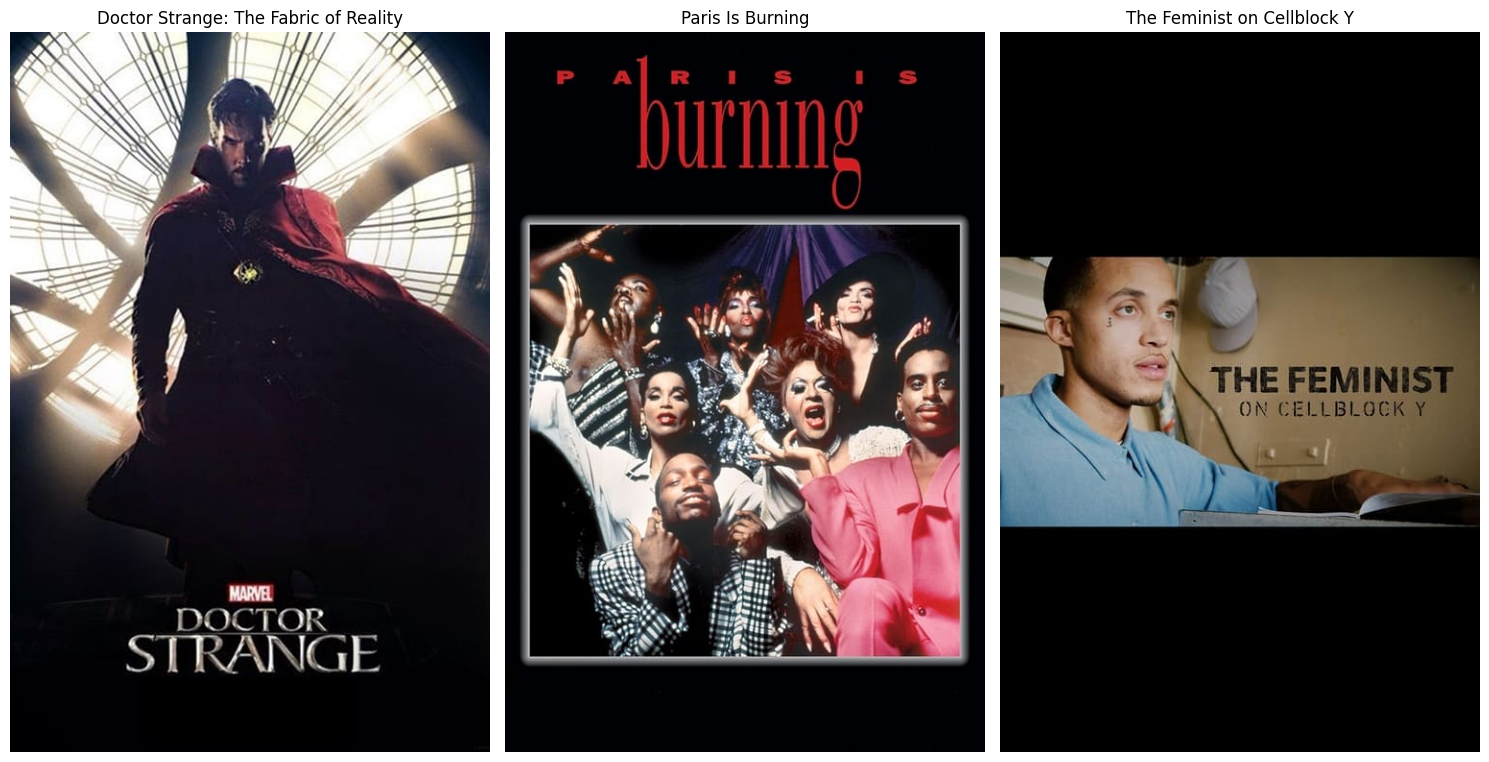

In [ ]:
result = poster_df[poster_df['id'].isin(a_recommend_id)]
result = result.set_index('id').loc[a_radar_ranking].reset_index()
fig, ax = plt.subplots(1, 3, figsize=(15,15))
for i, j in enumerate(result.poster_path.unique()):
    try:
        ax[i].axis('off')
        ax[i].set_title(result.title.unique()[i])
        a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
        ax[i].imshow(a)
    except: pass
fig.tight_layout()

<ipython-input-84-39dc03deb9e5>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-84-39dc03deb9e5>:38: UserWarning:

FixedFormatter should only be used together with FixedLocator



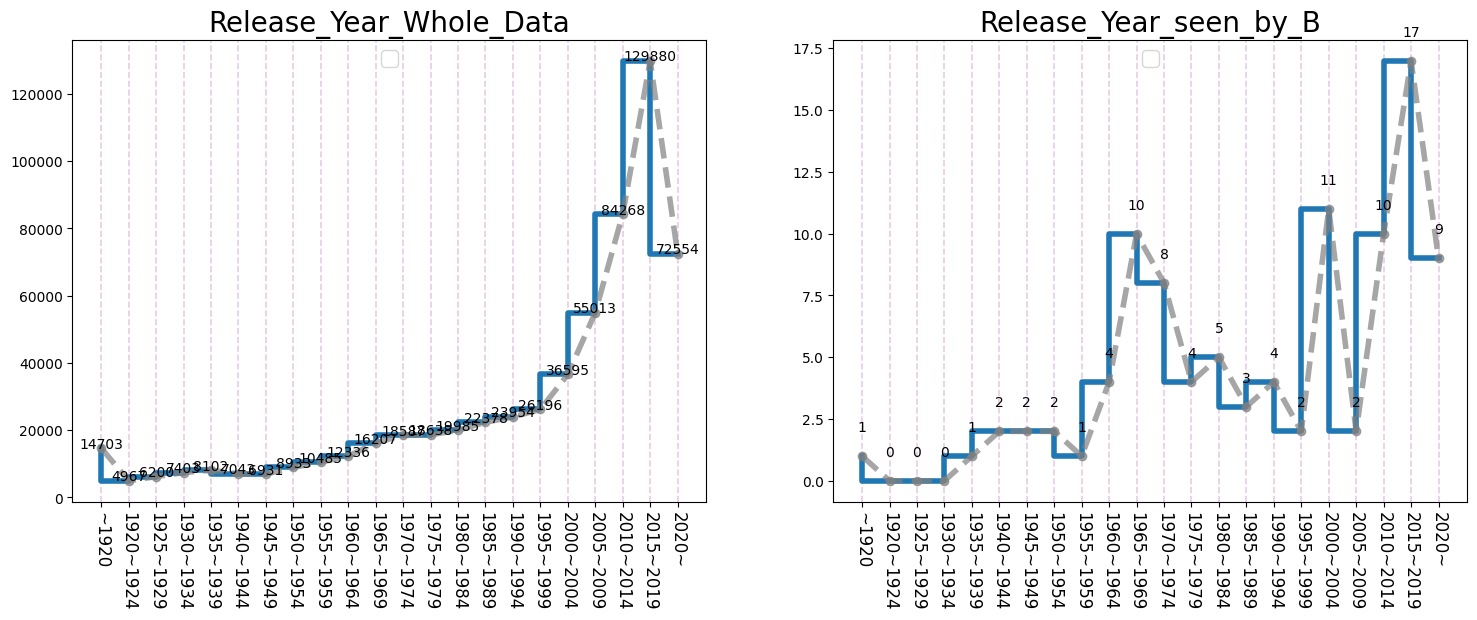

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

list_df = []
a = df[df["release_year"] < 1920]['id'].count() - df[df["release_year"] == 0]['id'].count()
list_df.append(a)
for i in np.arange(1920, 2020, 5):
    list_df.append(df[(df["release_year"] >= i) & (df["release_year"] < i + 5)]['id'].count())
b = df[df["release_year"] >= 2020]['id'].count()
list_df.append(b)

x= ["~1920", "1920~1924","1925~1929","1930~1934","1935~1939","1940~1944","1945~1949","1950~1954","1955~1959","1960~1964","1965~1969",'1970~1974','1975~1979','1980~1984','1985~1989','1990~1994','1995~1999','2000~2004','2005~2009','2010~2014','2015~2019','2020~']
y = list_df
ax[0].set_title("Release_Year_Whole_Data",fontsize = 20)
ax[0].step(x, y, lw = 4)
ax[0].plot(x, y,  "o--", color = '#808080', alpha = 0.7, linewidth=4)
ax[0].grid(axis ='x',color = 'purple', alpha = 0.2, ls = '--', lw =1.2)
ax[0].set_xticklabels(x, fontsize=12, rotation = 270)
ax[0].legend(loc = "upper center", fontsize = 15)

for idx, txt in enumerate(y):
    ax[0].text(x[idx], y[idx] + 1.0 , txt, ha = 'center', color = 'black')


list_B = []
a = b_df[b_df["release_year"] < 1920]['id'].count() - b_df[b_df["release_year"] == 0]['id'].count()
list_B.append(a)
for i in np.arange(1920, 2020, 5):
    list_B.append(b_df[(b_df["release_year"] >= i) & (b_df["release_year"] < i + 5)]['id'].count())
b = b_df[b_df["release_year"] >= 2020]['id'].count()
list_B.append(b)

x= ["~1920", "1920~1924","1925~1929","1930~1934","1935~1939","1940~1944","1945~1949","1950~1954","1955~1959","1960~1964","1965~1969",'1970~1974','1975~1979','1980~1984','1985~1989','1990~1994','1995~1999','2000~2004','2005~2009','2010~2014','2015~2019','2020~']
y = list_B
ax[1].set_title("Release_Year_seen_by_B",fontsize = 20)
ax[1].step(x, y, lw = 4)
ax[1].plot(x, y,  "o--", color = '#808080', alpha = 0.7, linewidth=4)
ax[1].grid(axis ='x',color = 'purple', alpha = 0.2, ls = '--', lw =1.2)
ax[1].set_xticklabels(x, fontsize=12, rotation = 270)
ax[1].legend(loc = "upper center", fontsize = 15)

for idx, txt in enumerate(y):
    ax[1].text(x[idx], y[idx] + 1.0 , txt, ha = 'center', color = 'black')
# Unlike the whole, B seems to be old because he watched a lot of movies in the 60s

In [ ]:
B_list = [word for words in b_df['genres'].values for word in words]
B_count = dict(Counter(B_list))
B_count = dict(sorted(B_count.items(), key=lambda x: x[1], reverse=True))
del B_count['']
B_count

{'Comedy': 30,
 'Drama': 18,
 'Documentary': 16,
 'Horror': 7,
 'Thriller': 5,
 'Mystery': 4,
 'Animation': 4,
 'Romance': 3,
 'Crime': 3,
 'Music': 3,
 'Western': 3,
 'Family': 2,
 'Action': 2,
 'Adventure': 2,
 'History': 1,
 'Fantasy': 1}

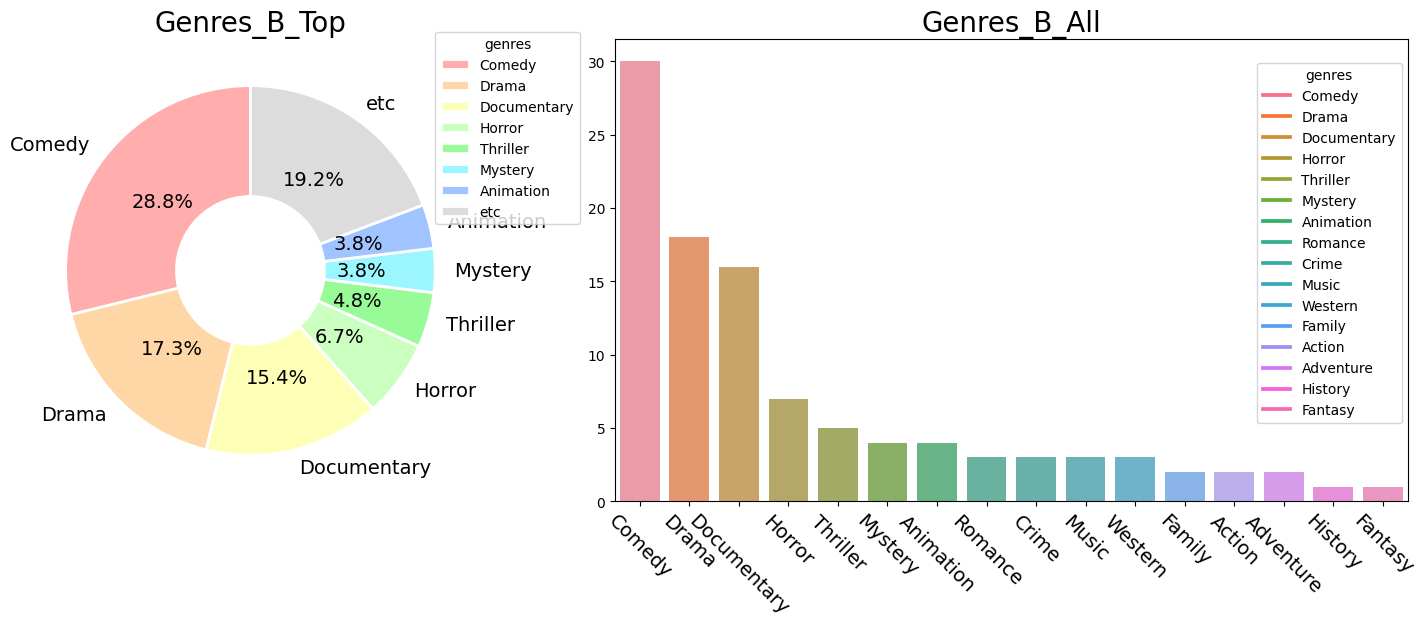

In [ ]:
# Selection of top genre based on 3%
top_genres_B = dict()
etc = 0 ; thres = 0.03
for key in B_count:
    if (B_count[key]/sum(B_count.values())) > thres:
        top_genres_B[key] = B_count[key]
    else :
        etc += B_count[key]
# top_genres_B[f'under {thres*100}%'] = etc
top_genres_B['etc'] = etc


# Top genre pie chart
def custom_autopct(pct):
    return('%.1f%%' %pct) if True else ''

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), gridspec_kw={'width_ratios': [3, 5]})

wedgeprops = {'width' : 0.6, 'edgecolor' : 'w', 'linewidth': 2}
colors = ['#ffadad', '#ffd6a5', '#fdffb6','#caffbf', '#98fb98', '#9bf6ff', '#a0c4ff','#dcdcdc']
ax[0].pie(top_genres_B.values(), labels = top_genres_B.keys(),  autopct= custom_autopct,
        startangle=90, wedgeprops = wedgeprops,colors = colors, textprops={'fontsize': 14})
ax[0].legend(title = "genres", loc = (0.9,0.6))
ax[0].set_title("Genres_B_Top", fontsize = 20)


# bar chart
x = list(B_count.keys())
y = list(B_count.values())

palette = sns.color_palette("husl", len(x))
sns.barplot(x=x,y=y, alpha=0.8, ax= ax[1], palette= palette)
ax[1].set_title('Genres_B_All', fontsize = 20)
ax[1].set_xticklabels(x,rotation = -45)
ax[1].tick_params(axis='x', labelsize=14)

legend = ax[1].legend(x, title = "genres", loc = (0.81,0.17))
lines = legend.get_lines()
for i in range(len(lines)):
    lines[i].set_color(palette[i])

plt.show()
# discoverable characteristics
# It is characterized by a preference for comedy, drama, and documentary.
# I think I prefer comfortable atmosphere & realistic movies to crime, thriller, and fantasy.

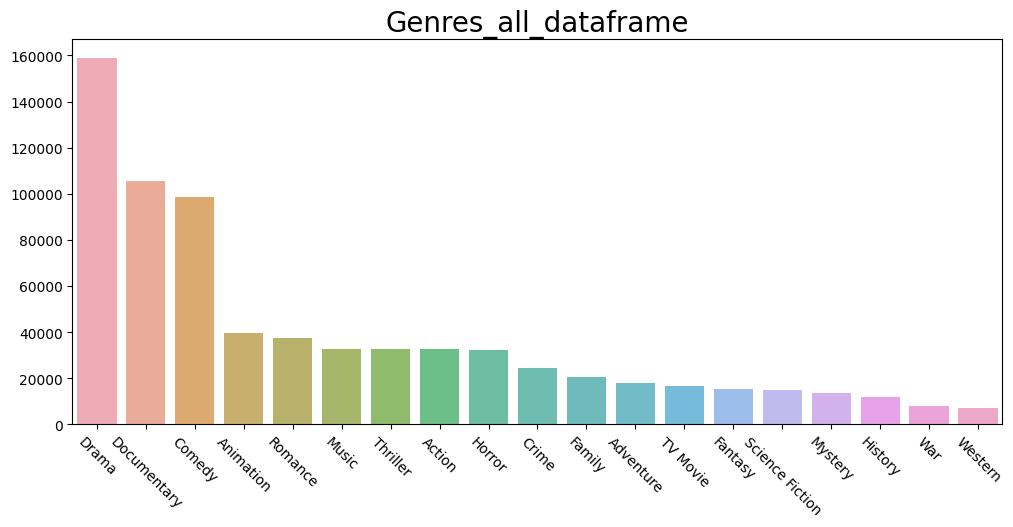

In [ ]:
df_list = [word for words in df['genres'].values for word in words]
df_count = dict(Counter(df_list))
df_count = dict(sorted(df_count.items(), key=lambda x: x[1], reverse=True))
del df_count['']

x = list(df_count.keys())
y = list(df_count.values())
plt.figure(figsize=(12,5))
sns.barplot(x=x,y=y, alpha=0.8)
plt.title('Genres_all_dataframe', fontsize = 20)
plt.xticks(rotation = -45)
plt.show()

In [ ]:
B_list = [word for words in b_df['credits'].values for word in words]
B_credits = dict(Counter(B_list))
B_credits = dict(sorted(B_credits.items(), key=lambda x: x[1], reverse=True))
del B_credits['']
B_credits

{'Vittorio Gassman': 4,
 'Edoardo Toniolo': 3,
 'Alain Cuny': 2,
 'Riccardo Garrone': 2,
 'Mino Doro': 2,
 'Jacques Sernas': 2,
 'Giuseppe Addobbati': 2,
 'Gabriella Andreini': 2,
 'Gianni Baghino': 2,
 'Ignazio Balsamo': 2,
 'Andrea De Pino': 2,
 'Carlo Kechler': 2,
 'Alessandro Borghi': 2,
 'Biagio Forestieri': 2,
 'Luisa Ranieri': 2,
 'Carmine Recano': 2,
 'Jean': 2,
 'Lidia Venturini': 2,
 'Ugo Tognazzi': 2,
 'Lando Buzzanca': 2,
 'Marino Masé': 2,
 'Mario Brega': 2,
 'Jacques Herlin': 2,
 'Quinto Parmeggiani': 2,
 'Nino Castelnuovo': 2,
 'Ornella Muti': 2,
 'Bianca Toso': 2,
 'Nino Frassica': 2,
 'Nicolas Vaporidis': 2,
 'Massimo Ghini': 2,
 'Alessandro Benvenuti': 2,
 'Gisella Sofio': 2,
 'Ilaria Occhini': 2,
 'Nello Pazzafini': 2,
 'Gianna Piaz': 2,
 'Vittorio Duse': 2,
 'Chris Avram': 2,
 'Lino Banfi': 2,
 'María Mercader': 2,
 'Flavio Sciolè': 2,
 'Valentina Bellè': 2,
 'Marcello Mastroianni': 1,
 'Anita Ekberg': 1,
 'Anouk Aimée': 1,
 'Yvonne Furneaux': 1,
 'Magali Noël': 1,


In [ ]:
credit_map = pd.DataFrame(B_credits, index = ['B_credits_COUNT'])
display(credit_map)

Vittorio Gassman  Edoardo Toniolo  Alain Cuny  \
B_credits_COUNT                 4                3           2   

                 Riccardo Garrone  Mino Doro  Jacques Sernas  \
B_credits_COUNT                 2          2               2   

                 Giuseppe Addobbati  Gabriella Andreini  Gianni Baghino  \
B_credits_COUNT                   2                   2               2   

                 Ignazio Balsamo  ...  Alessandra Berton  Martina Angelucci  \
B_credits_COUNT                2  ...                  1                  1   

                 Veronica Perrone  Liliana Fiorelli  Matteo Canesin  \
B_credits_COUNT                 1                 1               1   

                 Gino Cervi  Carlo Lepore  Vittorio Grigolo  Elsa Dreisig  \
B_credits_COUNT           1             1                 1             1   

                 Maxime Pascal  
B_credits_COUNT              1  

[1 rows x 965 columns]

In [ ]:
credit_dict = dict()
temp = credit_map.T.copy()
for i in range(1,4):
    credit_dict[i] = temp[temp['B_credits_COUNT']==i].index.tolist()

credit_dict2 = dict()
for k in credit_dict:
    new_list = [credit_dict[k][i:i+10] for i in range(0, len(credit_dict[k]), 10)]
    list1 = list() ; list2 =list()
    for i in range(len(new_list)):
        list1.append('|'.join(new_list[i]))
    credit_dict2[k] = '<br>'.join(list1)
# credit_dict2

In [ ]:
'''credit_dict = dict()
temp = credit_map.T.copy()
for i in range(1,4):
    credit_dict[i] = '|'.join(temp[temp['B_credits_COUNT']==i].index.tolist())'''

temp_df = pd.DataFrame(credit_dict2, index = ['freq']).T.reset_index()
temp_df.columns = ["Count",'credit']
temp_df['freq'] = temp_df['credit'].apply(lambda x : len(x.split('|')))
temp_df['credit'] =temp_df['credit'].str[:30]+"..."
temp_df['label'] = "Actor_Freq : "+temp_df['Count'].astype(str) + '<br>'+ 'Count :'+ \
                    temp_df['freq'].astype(str) + '<br>' + temp_df['credit'].astype(str)[:10]
temp_df

Count                             credit  freq  \
0      1  Marcello Mastroianni|Anita Ekb...   832   
1      2  Alain Cuny|Riccardo Garrone|Mi...    36   
2      3                 Edoardo Toniolo...     1   

                                               label  
0  Actor_Freq : 1<br>Count :832<br>Marcello Mastr...  
1  Actor_Freq : 2<br>Count :36<br>Alain Cuny|Ricc...  
2   Actor_Freq : 3<br>Count :1<br>Edoardo Toniolo...

In [ ]:
fig = px.treemap(temp_df, path=[px.Constant('Credit_Count_B'), 'label'], values='freq',
                 #color='freq', color_continuous_scale='RdBu',
                 #color_continuous_midpoint=np.average(temp_df['freq'], weights=temp_df['freq']),
                 color_discrete_sequence=["#f1ccb8", "#f1d4af", "#f2dfce"])


#fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=650,
    height=300,
    margin=dict(l=0, r=0, t=50, b=0)
)
fig.update_traces(textfont=dict(size=20),root_color="#e6e6e6")
fig.show()

ValueError: ignored

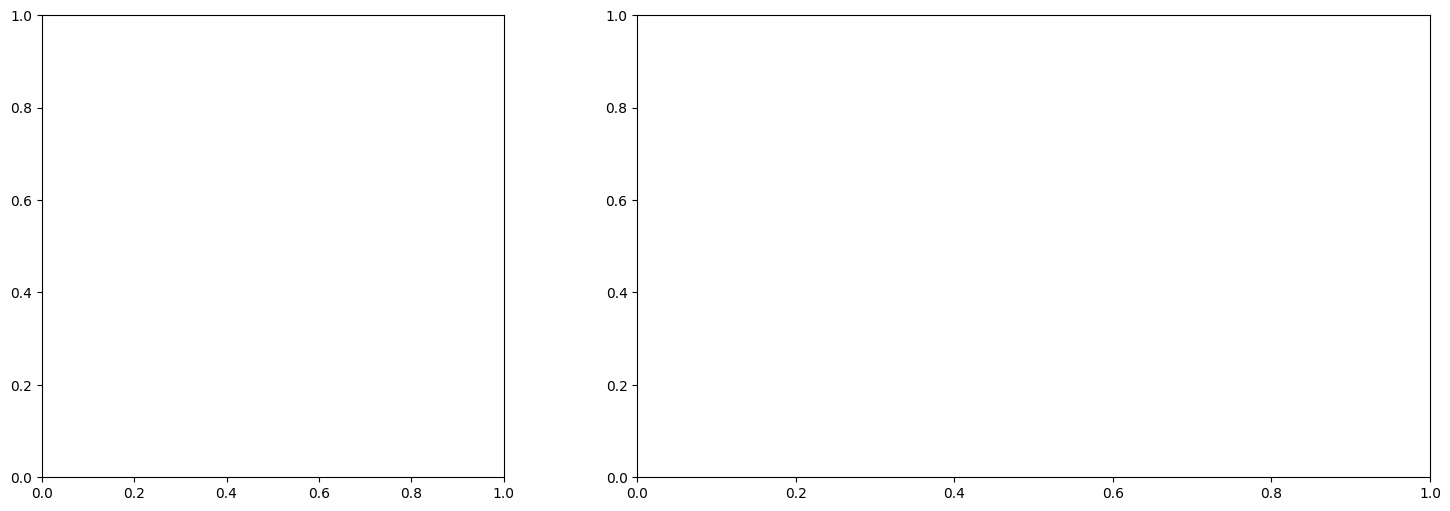

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), gridspec_kw={'width_ratios': [3, 5]})

B_temp = credit_map.T.value_counts()
def custom_autopct(pct):
    return('%.1f%%' %pct) if pct > 1 else ''

wedgeprops = {'width' : 0.6, 'edgecolor' : 'w', 'linewidth': 2}
colors = ['#ffd6a5', '#fdffb6','black','#dcdcdc']
ax[0].pie(B_temp.values.tolist(), labels = [1,2,3],  autopct= custom_autopct,
        startangle=90, wedgeprops = wedgeprops,colors = colors, textprops={'fontsize': 15})
ax[0].legend(title = "genres")
ax[0].set_title("Credit_Count_B", fontsize = 15)

x = ['Sacher Film', 'Dania Film', 'Rizzoli Film', 'PEA', '01Distribution', 'Italian\nInternational\nFilm', 'RAI', 'RAI Cinema']
colors = ['#F0EAD6', "#FFEFD5", "#FFE4C4", "#FFEBCD", "#F3E5AB", "#EED8AE", "#CDB79E", "#E0CDA9"]
ax[1].barh(list(top_company_B.keys())[::-1], list(top_company_B.values())[::-1], color=colors[::-1])
ax[1].set_title('Top_B_Company', fontsize = 20)
# plt.set_yticklabels(list(top_company_B.keys())[::-1],rotation = -45)
ax[1].set_xlabel('Frequency', fontsize = 14)
ax[1].tick_params(axis='both', labelsize=13)
for i, v in enumerate( list(top_company_B.values())[::-1]):
    ax[1].text(v+0.1, i, str(v), ha='center', fontsize = 12)

In [ ]:
b_df_list = [word for words in b_df['keywords'].values for word in words]
b_df_keywords = dict(Counter(b_df_list))
b_df_keywords = dict(sorted(b_df_keywords.items(), key=lambda x: x[1], reverse=True))
del b_df_keywords['']
b_df_keywords

{'italy': 3,
 'opera': 3,
 'gothic': 2,
 'erotic movie': 2,
 'whodunit': 2,
 'milan': 2,
 'short film': 2,
 'rome italy': 1,
 'sea': 1,
 'loss of loved one': 1,
 'lovesickness': 1,
 'sunrise': 1,
 'newspaper': 1,
 'photographer': 1,
 'sadness': 1,
 'night life': 1,
 'fountain': 1,
 'dying and death': 1,
 'unsociability': 1,
 'cowardliness': 1,
 'ghost': 1,
 'naples italy': 1,
 'napoli': 1,
 'hotel': 1,
 'journalist': 1,
 'identity': 1,
 'europe': 1,
 'passport': 1,
 'war correspondent': 1,
 'truck': 1,
 'reporter': 1,
 'desert': 1,
 'guide': 1,
 'republic of chad': 1,
 'road trip': 1,
 'carpool': 1,
 'trip': 1,
 'blind': 1,
 'italian': 1,
 'satire': 1,
 'social media influencer': 1,
 'hostage situation': 1,
 'election day': 1,
 'south italy': 1,
 'sibling relationship': 1,
 'greenhouse': 1,
 'gothic horror': 1,
 'tropical island': 1,
 'shipwrecked': 1,
 'pretending to be gay': 1,
 'gay theme': 1,
 'haiti': 1,
 'adolescence': 1,
 'orgy': 1,
 'sexual murder': 1,
 'high tech surveillance'

In [ ]:
from itertools import chain

b_key = set(b_df_keywords.keys())
b_related = pd.DataFrame(index=list(b_key), columns=list(b_key))
b_related.loc[:, :] = 0

for words in list(b_key):
    has = df['keywords'].apply(lambda x: words in x)
    result = set(list(chain(*df[has].keywords.values)))
    result.discard(words)
    result = list(result & b_key)
    b_related.loc[words,result] = 1
display(b_related)
B_heatmap = b_related.copy()

b_related['related_rank'] = b_related.sum(axis = 1)
b_related = b_related.sort_values(by='related_rank', ascending=False)

temp_join = pd.DataFrame(b_df_keywords, index = ['freq']).T
temp_join
b_related = b_related.join(temp_join, how='inner')
b_related['keyword_score'] = b_related['freq'] * b_related['related_rank']

display(b_related)

fired from the job stripper milan workers relationship  \
fired from the job                    0        0     0                    1   
stripper                              0        0     0                    0   
milan                                 0        0     0                    0   
workers relationship                  1        0     0                    0   
peplum                                0        0     0                    0   
...                                 ...      ...   ...                  ...   
early church                          0        0     0                    0   
sexual murder                         0        1     1                    0   
newspaper                             0        0     0                    0   
italian                               0        0     0                    0   
identity                              0        0     0                    0   

                     peplum comunism napoli infidelity election day  \
fired from the job        0        0      0          0            0   
stripper                  0        0      0          1            0   
milan                     0        0      0          1            0   
workers relationship      0        0      0          0            0   
peplum                    0        0      0          0            0   
...                     ...      ...    ...        ...          ...   
early church              0        0      0          0            0   
sexual murder             0        0      0          0            0   
newspaper                 0        0      0          1            0   
italian                   0        0      0          1            0   
identity                  0        0      0          1            0   

                     flavio sciolè  ... opera la scala sea atri shipwrecked  \
fired from the job               0  ...     0        0   0    0           0   
stripper                         0  ...     0        0   0    0           0   
milan                            0  ...     1        0   0    0           0   
workers relationship             0  ...     0        0   0    0           0   
peplum                           0  ...     0        0   0    0           0   
...                            ...  ...   ...      ...  ..  ...         ...   
early church                     0  ...     0        0   0    0           0   
sexual murder                    0  ...     0        0   0    0           0   
newspaper                        0  ...     0        0   1    0           0   
italian                          0  ...     1        0   0    0           0   
identity                         0  ...     0        0   0    0           0   

                     early church sexual murder newspaper italian identity  
fired from the job              0             0         0       0        0  
stripper                        0             1         0       0        0  
milan                           0             1         0       0        0  
workers relationship            0             0         0       0        0  
peplum                          0             0         0       0        0  
...                           ...           ...       ...     ...      ...  
early church                    0             0         0       0        0  
sexual murder                   0             0         0       0        0  
newspaper                       0             0         0       0        0  
italian                         0             0         0       0        0  
identity                        0             0         0       0        0  

[108 rows x 108 columns]

fired from the job stripper milan workers relationship  \
short film                            1        1     1                    1   
italy                                 1        0     1                    1   
sibling relationship                  0        1     1                    1   
hotel                                 0        1     0                    1   
ghost                                 0        1     0                    1   
...                                 ...      ...   ...                  ...   
flavio sciolè                         0        0     0                    0   
la scala                              0        0     0                    0   
jazz fusion                           0        0     0                    0   
maturity                              0        0     0                    0   
comunism                              0        0     0                    0   

                     peplum comunism napoli infidelity election day  \
short film                0        0      1          1            0   
italy                     0        0      1          1            1   
sibling relationship      1        0      0          1            0   
hotel                     0        0      0          1            0   
ghost                     1        0      0          1            0   
...                     ...      ...    ...        ...          ...   
flavio sciolè             0        0      0          0            0   
la scala                  0        0      0          0            0   
jazz fusion               0        0      0          0            0   
maturity                  0        0      0          0            0   
comunism                  0        0      0          0            0   

                     flavio sciolè  ... atri shipwrecked early church  \
short film                       0  ...    0           1            0   
italy                            0  ...    0           0            0   
sibling relationship             0  ...    0           0            0   
hotel                            0  ...    0           0            0   
ghost                            0  ...    0           0            0   
...                            ...  ...  ...         ...          ...   
flavio sciolè                    0  ...    1           0            0   
la scala                         0  ...    0           0            0   
jazz fusion                      0  ...    0           0            0   
maturity                         0  ...    0           0            0   
comunism                         0  ...    0           0            0   

                     sexual murder newspaper italian identity related_rank  \
short film                       0         1       1        1         69.0   
italy                            0         0       1        0         54.0   
sibling relationship             0         1       0        1         53.0   
hotel                            0         1       1        1         49.0   
ghost                            1         1       0        0         48.0   
...                            ...       ...     ...      ...          ...   
flavio sciolè                    0         0       0        0          2.0   
la scala                         0         0       0        0          2.0   
jazz fusion                      0         0       0        0          1.0   
maturity                         0         0       0        0          1.0   
comunism                         0         0       0        0          0.0   

                     freq keyword_score  
short film              2         138.0  
italy                   3         162.0  
sibling relationship    1          53.0  
hotel                   1          49.0  
ghost                   1          48.0  
...                   ...           ...  
flavio sciolè           1           2.0  
la scala                1           2.0  
jazz fusion             1  

In [ ]:
colorscale = [
    [0, "#f7e6d2"],
    [0.2, "#f1c6a6"],
    [0.4, "#eaa783"],
    [0.6, "#e2856e"],
    [0.8, "#d15e5a"],
    [1, "#b12c41"],
]

max_vals = B_heatmap.max().max()
min_vals = B_heatmap.min().min()

# Min-Max Scaling
B_heatmap = (B_heatmap - min_vals) / (max_vals - min_vals)
fig = go.Figure(data=go.Heatmap(z= B_heatmap,
                                x= B_heatmap.index.tolist(),
                                y= B_heatmap.columns.tolist(),
                                colorscale='YlGnBu'))
fig.update_layout(
    title={
        'text':'Keyword Network heatmap_B',
        'x': 0.55,
        'y': 0.96
    },
    margin=dict(l=0, r=0, t=50, b=0)
    #,xaxis=dict(title='X Axis')
    #,yaxis=dict(title='Keyw')
)
fig.update_layout(width=600, height=600)
fig.show()

In [ ]:
keyword_dict = dict(b_related['keyword_score'])
b_recommend['keyword_score'] = 0
for keyword in keyword_dict:
    b_recommend.loc[b_recommend['keywords'].apply(lambda x: keyword in x), 'keyword_score'] += keyword_dict[keyword]

b_recommend['genre_score'] = 0
for genre in B_count:
    b_recommend.loc[b_recommend['genres'].apply(lambda x: genre in x), 'genre_score'] += B_count[genre]
b_recommend

b_recommend['company_score'] = 0
for company in B_company:
    b_recommend.loc[b_recommend['production_companies'].apply(lambda x: company in x), 'company_score'] += B_company[company]
b_recommend

id                                             title  \
0       615656                                 Meg 2: The Trench   
1       758323                               The Pope's Exorcist   
2       667538                  Transformers: Rise of the Beasts   
3       640146                 Ant-Man and the Wasp: Quantumania   
4       677179                                         Creed III   
...        ...                                               ...   
662078  741629                                        Blitzkrieg   
662079  430327  Con aura senz'aura. Viaggio ai confini dell'arte   
662080  633623                                     Midsommarvaka   
662081  294742                                 Gospođa- Slobodan   
662082  968161                                     Gising Sining   

                                      genres original_language  popularity  \
0          [Action, Science Fiction, Horror]                en    8763.998   
1                [Horror, Mystery, Thriller]                en    5953.227   
2       [Action, Adventure, Science Fiction]                en    5409.104   
3       [Action, Adventure, Science Fiction]                en    4425.387   
4                            [Drama, Action]                en    3994.342   
...                                      ...               ...         ...   
662078                              [Horror]                es       0.600   
662079                                    []                it       0.600   
662080                               [Music]                xx       0.600   
662081                                    []                en       0.600   
662082                                    []                tl       0.600   

                                     production_companies release_date  \
0       Apelles Entertainment-Warner Bros. Pictures-di...   2023-08-02   
1       Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...   2023-04-05   
2       Skydance-Paramount-di Bonaventura Pictures-Bay...   2023-06-06   
3                  Marvel Studios-Kevin Feige Productions   2023-02-15   
4       Metro-Goldwyn-Mayer-Proximity Media-Balboa Pro...   2023-03-01   
...                                                   ...          ...   
662078                                                      2020-10-01   
662079                                                      2003-02-02   
662080                                         SF Studios   1947-12-26   
662081                                                             NaN   
662082                                          Studio RD          NaN   

             budget      revenue  runtime  ... vote_average  vote_count  \
0       129000000.0  352056482.0    116.0  ...            7      1365.0   
1        18000000.0   65675816.0    103.0  ...            7       545.0   
2       200000000.0  407045464.0    127.0  ...            7      1007.0   
3       200000000.0  475766228.0    125.0  ...            6      2811.0   
4        75000000.0  269000000.0    116.0  ...            7      1129.0   
...             ...          ...      ...  ...          ...         ...   
662078          0.0          0.0      8.0  ...            6         1.0   
662079          0.0          0.0      NaN  ...            0         0.0   
662080          0.0          0.0     11.0  ...            0         0.0   
662081          0.0          0.0      5.0  ...            0         0.0   
662082          0.0          0.0     19.0  ...            0         0.0   

                                                  credits  \
0       [Jason Statham, Wu Jing, Shuya Sophia Cai, Ser...   
1       [Russell Crowe, Daniel Zovatto, Alex Essoe, Fr...   
2       [Anthony Ramos, Dominique Fishback, Luna Laure...   
3       [Paul Rudd, Evangeline Lilly, Jonathan Majors,...   
4       [Michael B. Jordan, Tessa Thompson, Jonathan M...   
...                                                   ...   
662078                                   

In [ ]:
b_score = b_recommend[['id', 'log_popularity','vote_average','company_score','genre_score','keyword_score']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(b_score.iloc[:,1:])
scaled_b_score = pd.DataFrame(X_scaled, columns=b_score.iloc[:,1:].columns, index = b_score['id'])
scaled_b_score

log_popularity  vote_average  company_score  genre_score  \
id                                                                 
615656        1.000000           0.7       0.886724     0.105882   
758323        0.975610           0.7       0.877588     0.188235   
667538        0.951220           0.7       0.862972     0.047059   
640146        0.926829           0.6       0.786845     0.047059   
677179        0.926829           0.7       0.855664     0.235294   
...                ...           ...            ...          ...   
741629        0.000000           0.6       0.000000     0.082353   
430327        0.000000           0.0       0.000000     0.000000   
633623        0.000000           0.0       0.403167     0.035294   
294742        0.000000           0.0       0.000000     0.000000   
968161        0.000000           0.0       0.369671     0.000000   

        keyword_score  
id                     
615656       0.000000  
758323       0.068716  
667538       0.059675  
640146       0.000000  
677179       0.000000  
...               ...  
741629       0.000000  
430327       0.000000  
633623       0.249548  
294742       0.000000  
968161       0.000000  

[662079 rows x 5 columns]